## Introduction ##

The objective of this notebook is to build an automated human activity recognition system. Main goal is to obtain highest cross-validated activity prediction performance by applying various data preprocessing and machine learning methods and tuning their parameters.

Labeled human acitivity used in this study is publicly available on Kaggle[1].

Throughout this workbook, I will follow an iterative process where I will go back and forward to apply various data visualization, data preprocessing and model-training methods while paying special attention on:
- training time,
- testing time,
- prediction performance

My goal is, eventually, to learn more about the nature of the problem of activity recognition. I will mostly have an application developer view when I discuss the real life implications of the obtained results.

[1] Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21st European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013 [ https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones ]

In [1]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

class_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
class_ids = range(6)

X_train = pd.read_csv('train.csv')
s_train = X_train['subject']
X_train.drop('subject', axis = 1, inplace = True)
y_train = X_train['Activity'].to_frame().reset_index()
X_train.drop('Activity', axis = 1, inplace = True)
y_train = y_train.replace(class_labels, [0, 1, 2, 3, 4, 5])

X_test = pd.read_csv('test.csv')
s_test = X_test['subject']
X_test.drop('subject', axis = 1, inplace = True)
y_test = X_test['Activity'].to_frame().reset_index()
X_test.drop(['Activity'], axis = 1, inplace = True)
y_test = y_test.replace(class_labels, [0, 1, 2, 3, 4, 5])

#NOTE: this contenation method (viz. append) is safer than concat
X = X_train.append(X_test, ignore_index=True)
y = y_train.append(y_test, ignore_index=True)

print X.shape
print y.shape

display(X.describe())
# display(y.describe())

#NOTE: append can adjust the index value of the appended dataframe whereas concatenation cannot. Concatenation may
#result in duplicate indices.
# dataframes = [X_train, X_test]
# X = pd.concat(dataframes)
# dataframes = [y_train, y_test]
# y = pd.concat(dataframes)

(10299, 561)
(10299, 2)


tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       10299.000000       10299.000000       10299.000000   
mean            0.274347          -0.017743          -0.108925   
std             0.067628           0.037128           0.053033   
min            -1.000000          -1.000000          -1.000000   
25%             0.262625          -0.024902          -0.121019   
50%             0.277174          -0.017162          -0.108596   
75%             0.288354          -0.010625          -0.097589   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      10299.000000      10299.000000      10299.000000      10299.000000   
mean          -0.607784         -0.510191         -0.613064         -0.633593   
std            0.438694          0.500240          0.403657          0.413333   
min           -1.000000         -1.000000         -1.000000         -1.000000   
25%           -0.992360         -0.976990         -0.979137         -0.993293   
50%           -0.943030         -0.835032         -0.850773         -0.948244   
75%           -0.250293         -0.057336         -0.278737         -0.302033   
max            1.000000          1.000000          1.000000          1.000000   

       tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  \
count      10299.000000      10299.000000      10299.000000   
mean          -0.525697         -0.614989         -0.466732   
std            0.484201          0.399034          0.538707   
min           -1.000000         -1.000000         -1.000000   
25%           -0.977017         -0.979064         -0.935788   
50%           -0.843670         -0.845068         -0.874825   
75%           -0.087405         -0.288149         -0.014641   
max            1.000000          1.000000          1.000000   

               ...           fBodyBodyGyroJerkMag-meanFreq()  \
count          ...                              10299.000000   
mean           ...                                  0.126708   
std            ...                                  0.245443   
min            ...                                 -1.000000   
25%            ...                                 -0.019481   
50%            ...                                  0.136245   
75%            ...                                  0.288960   
max            ...                                  1.000000   

       fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
count                     10299.000000                     10299.000000   
mean                         -0.298592                        -0.617700   
std                           0.320199                         0.308796   
min                          -1.000000                        -1.000000   
25%                          -0.536174                        -0.841847   
50%                          -0.335160                        -0.703402   
75%                          -0.113167                        -0.487981   
max                           1.000000                         1.000000   

       angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
count                 10299.000000                          10299.000000   
mean                      0.007705                              0.002648   
std                       0.336591                              0.447364   
min                      -1.000000                             -1.000000   
25%                      -0.124694                             -0.287031   
50%                       0.008146                              0.007668   
75%                       0.149005                              0.291490   
max                       1.000000                              1.000000   

       angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
count                      10299.000000                          10299.000000   
mean          

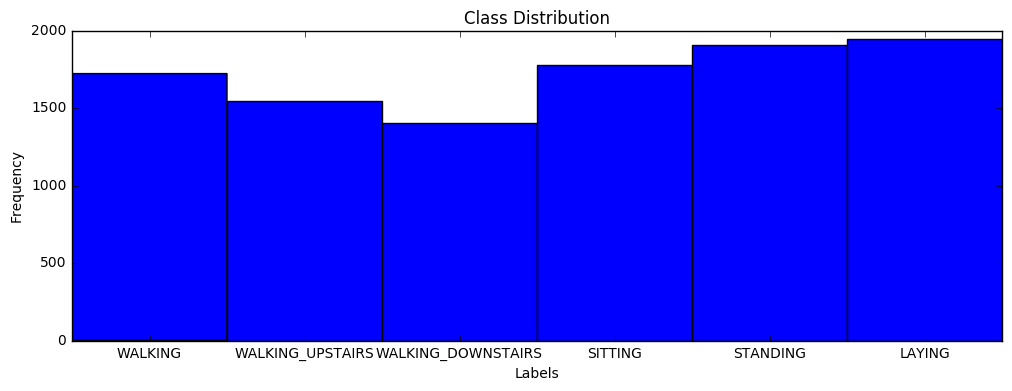

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# print np.histogram(y['Activity'], bins=len(class_ids))

plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.xticks(class_ids, class_labels)
plt.hist(y['Activity'], bins=np.arange(len(class_ids)+1)-0.5)
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()

## Iteration 1: Comparison of baseline classifiers ##

Before going into a more detailed work on the features and model training and testing, I will apply some of the supervised machine learning methods to have some idea about the baseline performance of those methods.

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.metrics import precision_recall_fscore_support
from time import time

from sklearn.metrics import classification_report

from sklearn import preprocessing
from scipy.stats import boxcox
import operator

import warnings
warnings.filterwarnings('ignore')

def GetClassificationPerformance(clf, data, labels, n_folds, text):
    results_precision = []
    results_recall = []
    results_fscore = []
    results_ttrain = []
    results_ttest = []
    
    kfold = cross_validation.KFold(data.shape[0], n_folds=n_folds, shuffle=False, random_state=42)
    for train, test in kfold:
        # train
        t_start = time()
        clf.fit(data.iloc[train], labels.iloc[train])
        results_ttrain.append( time() - t_start )
        
        # test
        t_start = time()
        pred = clf.predict(data.iloc[test])
        results_ttest.append( time() - t_start )
        
        #measure
        precision, recall, fscore, support = precision_recall_fscore_support(labels.iloc[test], pred, average='weighted')
        results_precision.append(precision)
        results_recall.append(recall)
        results_fscore.append(fscore)
    
    printout = str(text)
    printout += " precision:{:.2f}".format(np.mean(results_precision))
    printout += " recall:{:.2f}".format(np.mean(results_recall))
    printout += " fscore:{:.2f}  ".format(np.mean(results_fscore))
    printout += " t_train:{:.2f} t_test:{:.2f}".format(np.mean(results_ttrain), np.mean(results_ttest))
    print printout
    
    return [np.mean(results_precision), np.mean(results_recall), np.mean(results_fscore), np.mean(results_ttrain), np.mean(results_ttest)]

def CreateFeatureSet2(data, data_tf, kbest, n_pca):
    # Extrace KBest features
    t_start = time()
    if kbest != 0:
        f_selector = SelectKBest(k=kbest)
        Xs = f_selector.fit(data_tf, y['Activity'].to_frame()).transform(data_tf)
        f_selected_indices = f_selector.get_support(indices=False)
        Xs_cols = data.columns[f_selected_indices]
        Xs_df = pd.DataFrame(Xs, columns = Xs_cols)
    t_kbest = time() - t_start

    # Extrace nPCA components
    t_start_2 = time()
    if n_pca != 0:
        pca = PCA(n_components=n_pca).fit(data)
        X_pcaed = pca.transform(data)
        dimensions = []
        for i in range(0, n_pca):
            dimensions.append("comp_{:3d}".format(i))
        X_pcaed_df = pd.DataFrame(X_pcaed, columns = dimensions)

    t_npca = time() - t_start_2        
    data_combined = pd.DataFrame()

    if kbest != 0 and n_pca != 0:
        # Combine KBest and nPCA features
        data_combined = pd.concat([Xs_df, X_pcaed_df], axis=1)
    elif kbest == 0:
        data_combined = X_pcaed_df
    elif n_pca == 0:
        data_combined = Xs_df

    t_total = time() - t_start
    return data_combined, [t_kbest, t_npca, t_total]

def CreateFeatureSet(data, kbest, n_pca):
    # Extrace KBest features
    t_start = time()
    if kbest != 0:
        X_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(data)
        X_bxcxed = boxCoxData(X_scaled)
        X_bxcxed_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(X_bxcxed)
        f_selector = SelectKBest(k=kbest)
        Xs = f_selector.fit(X, y['Activity'].to_frame()).transform(data)
        f_selected_indices = f_selector.get_support(indices=False)
        Xs_cols = X.columns[f_selected_indices]
        Xs_df = pd.DataFrame(Xs, columns = Xs_cols)
    t_kbest = time() - t_start

    # Extrace nPCA components
    t_start_2 = time()
    if n_pca != 0:
        pca = PCA(n_components=n_pca).fit(data)
        X_pcaed = pca.transform(data)
        dimensions = []
        for i in range(0, n_pca):
            dimensions.append("comp_{:3d}".format(i))
        X_pcaed_df = pd.DataFrame(X_pcaed, columns = dimensions)

    t_npca = time() - t_start_2        
    data_combined = pd.DataFrame()

    if kbest != 0 and n_pca != 0:
        # Combine KBest and nPCA features
        data_combined = pd.concat([Xs_df, X_pcaed_df], axis=1)
    elif kbest == 0:
        data_combined = X_pcaed_df
    elif n_pca == 0:
        data_combined = Xs_df

    t_total = time() - t_start
    return data_combined, [t_kbest, t_npca, t_total]

def boxCoxData(data):
    data_bxcxed = []
    for feature in range(data.shape[1]):
        data_bxcxed_feature, maxlog = boxcox(data[:,feature])
        if feature == 0:
            data_bxcxed = data_bxcxed_feature
        else:
            data_bxcxed = np.column_stack([data_bxcxed, data_bxcxed_feature])
    return data_bxcxed

clf_SGD = SGDClassifier(random_state = 42)
clf_Ada = AdaBoostClassifier(random_state = 42)
clf_DTR = DecisionTreeRegressor(random_state=42)
clf_KNC = KNeighborsClassifier()
clf_GNB = GaussianNB()
clf_SVM = SVC()

clfs = {clf_SGD, clf_Ada, clf_DTR, clf_KNC, clf_GNB, clf_SVM}

In [5]:
for clf in clfs:
    printout = ""
    if clf == clf_SGD: printout = "SGD"
    elif clf == clf_Ada: printout = "Ada"
    elif clf == clf_DTR: printout = "DTR"
    elif clf == clf_KNC: printout = "KNC"
    elif clf == clf_GNB: printout = "GNB"
    elif clf == clf_SVM: printout = "SVM"

    GetClassificationPerformance(clf, X, y["Activity"].to_frame(), 10, printout)

DTR precision:0.88 recall:0.87 fscore:0.87   t_train:5.25 t_test:0.01
Ada precision:0.37 recall:0.54 fscore:0.41   t_train:30.49 t_test:0.03
GNB precision:0.80 recall:0.73 fscore:0.72   t_train:0.18 t_test:0.05
SGD precision:0.95 recall:0.94 fscore:0.94   t_train:0.33 t_test:0.01
SVM precision:0.94 recall:0.94 fscore:0.93   t_train:9.81 t_test:2.37
KNC precision:0.91 recall:0.91 fscore:0.91   t_train:0.66 t_test:8.73


## Iteration 2: Outlier and NaN detection ##

Let's check if the feature values are properly calculated and if the data has impurities or missing values. Moreover, let's check if the dataset has outliers.

In [6]:
print X.isnull().values.any()

False


In [7]:
print X.isnull().values.sum()

0


In [8]:
X_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(X)
X_bxcxed = boxCoxData(X_scaled)
X_bxcxed_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(X_bxcxed)

outliers = []
for feature in range(X_bxcxed_scaled.shape[1]):
    Q1 = np.percentile(X_bxcxed_scaled[:, feature], 25)
    Q3 = np.percentile(X_bxcxed_scaled[:, feature], 75)
    step = 1.5 * (Q3 - Q1)

    outlier_filter = ~((X_bxcxed_scaled[:, feature] >= Q1 - step) & (X_bxcxed_scaled[:, feature] <= Q3 + step))
    
    cnt = 0
    for outlier in outlier_filter:
        if outlier:
            outliers.append(cnt)
        cnt += 1
    
# print "number of outliers with repeating indices: " + str(len(outliers))

id2cnt = {}
for outlier in outliers:
    if not outlier in id2cnt:
        id2cnt[outlier] = 1
    else:
        id2cnt[outlier] += 1

In [9]:
sorted_id2cnt = sorted(id2cnt.items(), key=operator.itemgetter(1), reverse=True)
# print sorted_id2cnt

In [10]:
cnt2nindices = {}
for key, value in sorted_id2cnt:
    #only remove the outliers that are repeated more than once
    if value <=1:
        break
    if not value in cnt2nindices:
        cnt2nindices[value] = 1
    else:
        cnt2nindices[value] += 1

#NOTE: Uncomment for details
for key, value in cnt2nindices.iteritems():
    print "{:2d} features share {:4d} potential outliers".format(key, value)

 2 features share  367 potential outliers
 3 features share  825 potential outliers
 4 features share  825 potential outliers
 5 features share  716 potential outliers
 6 features share  663 potential outliers
 7 features share  893 potential outliers
 8 features share  808 potential outliers
 9 features share  704 potential outliers
10 features share  576 potential outliers
11 features share  426 potential outliers
12 features share  294 potential outliers
13 features share  156 potential outliers
14 features share   96 potential outliers
15 features share   50 potential outliers
16 features share   27 potential outliers
17 features share   31 potential outliers
18 features share   12 potential outliers
19 features share   15 potential outliers
20 features share    7 potential outliers
21 features share    9 potential outliers
22 features share    7 potential outliers
23 features share    2 potential outliers
24 features share    1 potential outliers
25 features share    8 potential o

In [14]:
# make a dictionary of indices based on the number of features that mark them as outliers
cnt2indices = {}
for key, value in sorted_id2cnt:
    #only remove the outliers that are repeated more than once
    if not value in cnt2indices:
        cnt2indices[value] = []
    cnt2indices[value].append(key)

outliers = []
results = []
# NOTE: Uncomment these lines to see how the classifier perform with the removal of
# potential outliers.
for key in sorted(cnt2indices.iterkeys(), reverse=True):
#     print "removing",
    outliers = outliers + cnt2indices[key]
#     print "{:3d} many {:d}d outliers".format(len(cnt2indices[key]), key)
    
    X_bxcxed_scaled_df = pd.DataFrame(X_bxcxed_scaled, columns = X.columns)
    X_filtered = X_bxcxed_scaled_df.drop(outliers)
    y_filtered = y.drop(outliers)
    
    print "SVM with",
    results = GetClassificationPerformance(clf_SVM, X_filtered, y_filtered['Activity'].to_frame(), 10, "{:5d}".format(X_filtered.shape[0]))


 SVM with 10297 precision:0.94 recall:0.94 fscore:0.94   t_train:8.50 t_test:2.14
SVM with 10296 precision:0.94 recall:0.94 fscore:0.94   t_train:8.53 t_test:2.18
SVM with 10294 precision:0.94 recall:0.94 fscore:0.94   t_train:8.44 t_test:2.11
SVM with 10286 precision:0.94 recall:0.94 fscore:0.94   t_train:8.38 t_test:2.11
SVM with 10285 precision:0.94 recall:0.94 fscore:0.94   t_train:8.36 t_test:2.11
SVM with 10283 precision:0.94 recall:0.94 fscore:0.94   t_train:8.40 t_test:2.11
SVM with 10276 precision:0.94 recall:0.94 fscore:0.94   t_train:8.34 t_test:2.10
SVM with 10267 precision:0.94 recall:0.94 fscore:0.94   t_train:8.32 t_test:2.10
SVM with 10260 precision:0.94 recall:0.94 fscore:0.94   t_train:8.31 t_test:2.10
SVM with 10245 precision:0.94 recall:0.94 fscore:0.94   t_train:8.31 t_test:2.10
SVM with 10233 precision:0.94 recall:0.94 fscore:0.94   t_train:8.25 t_test:2.08
SVM with 10202 precision:0.94 recall:0.94 fscore:0.93   t_train:8.17 t_test:2.06
SVM with 10175 precision:0.

ValueError: pos_label=1 is not a valid label: array([3, 4], dtype=int64)

In [15]:
X_scaled_sqrted = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(np.sqrt(X_scaled))
X_scaled_sqrted_df = pd.DataFrame(X_scaled_sqrted, columns = X.columns)
X_scaled_logged = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(np.log(X_scaled))
X_scaled_logged_df = pd.DataFrame(X_scaled_logged, columns = X.columns)

GetClassificationPerformance(clf_SVM, X, y["Activity"].to_frame(), 10, "SVM noprocced  ".format(X.shape[0]))
GetClassificationPerformance(clf_SVM, X_scaled_sqrted_df, y['Activity'].to_frame(), 10, "SVM with sqrted".format(X.shape[0]))
GetClassificationPerformance(clf_SVM, X_scaled_logged_df, y['Activity'].to_frame(), 10, "SVM with logged".format(X.shape[0]))
GetClassificationPerformance(clf_SVM, X_bxcxed_scaled_df, y['Activity'].to_frame(), 10, "SVM with bxcxed".format(X.shape[0]))

 SVM noprocced   precision:0.94 recall:0.94 fscore:0.93   t_train:10.06 t_test:2.41
SVM with sqrted precision:0.94 recall:0.94 fscore:0.94   t_train:9.75 t_test:2.36
SVM with logged precision:0.94 recall:0.94 fscore:0.94   t_train:9.60 t_test:2.34
SVM with bxcxed precision:0.94 recall:0.94 fscore:0.94   t_train:8.44 t_test:2.11


[0.9416654570527403,
 0.93630643380792,
 0.93534908912674553,
 8.4449999570846561,
 2.1087000608444213]

In [217]:
from sklearn.feature_selection import SelectKBest

d_kbest_to_precision = {}
d_kbest_to_recall = {}
d_kbest_to_f1score = {}

# kbest_max = X.shape[1]/5
kbest_max = 118
# kbest_max = 18

d_kbest2precision = {}
d_kbest2recall = {}
d_kbest2fscore = {}
d_kbest2ttrain = {}
d_kbest2ttest = {}

tmp_clf = SVC()

for kbest in range (2, kbest_max):
    Xs_df, times = CreateFeatureSet(X, kbest, 0)
    print "SVM KBest={:3d}".format(kbest),
    result = GetClassificationPerformance(tmp_clf, Xs_df, y["Activity"].to_frame(), 10, "")
    d_kbest2precision = result[0]
    d_kbest2recall = result[1]
    d_kbest2fscore = result[2]
    d_kbest2ttrain = result[3]
    d_kbest2ttest = result[4]

 SVM KBest=  2  precision:0.73 recall:0.69 fscore:0.67   t_train:1.33 t_test:0.24
SVM KBest=  3  precision:0.74 recall:0.70 fscore:0.68   t_train:1.40 t_test:0.26
SVM KBest=  4  precision:0.74 recall:0.70 fscore:0.68   t_train:1.43 t_test:0.26
SVM KBest=  5  precision:0.73 recall:0.70 fscore:0.68   t_train:1.41 t_test:0.27
SVM KBest=  6  precision:0.74 recall:0.71 fscore:0.70   t_train:1.32 t_test:0.27
SVM KBest=  7  precision:0.75 recall:0.72 fscore:0.70   t_train:1.37 t_test:0.29
SVM KBest=  8  precision:0.76 recall:0.73 fscore:0.71   t_train:1.38 t_test:0.28
SVM KBest=  9  precision:0.76 recall:0.73 fscore:0.71   t_train:1.36 t_test:0.29
SVM KBest= 10  precision:0.78 recall:0.75 fscore:0.73   t_train:1.28 t_test:0.28
SVM KBest= 11  precision:0.82 recall:0.79 fscore:0.78   t_train:1.11 t_test:0.25
SVM KBest= 12  precision:0.83 recall:0.79 fscore:0.77   t_train:1.17 t_test:0.26
SVM KBest= 13  precision:0.83 recall:0.80 fscore:0.78   t_train:1.19 t_test:0.26
SVM KBest= 14  precision:0.

Precision, recall and fscore values are calculated based on the class weighted average as there is imbalance between the number of class labels in the dataset.

I will consider the best 16 features to further investigate. This is where the classification scores peak for the first time, and it doesn't change that much after that point on.

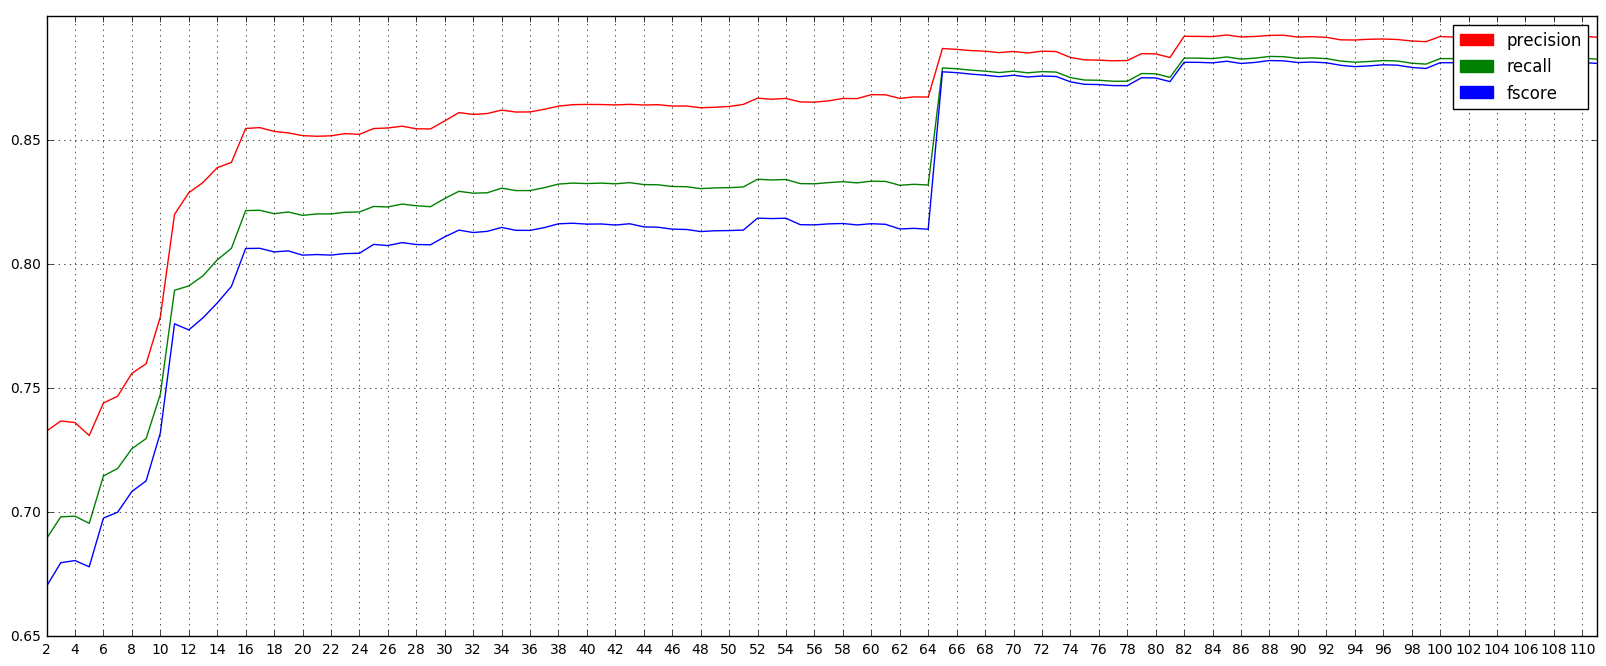

In [84]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.grid(True)
major_ticks = np.arange(0, kbest_max, 10) 
minor_ticks = np.arange(0, kbest_max, 2)

plt.xticks(minor_ticks)
plt.plot(d_kbest2precision.keys(), d_kbest2precision.values(), 'r',
        d_kbest2recall.keys(), d_kbest2recall.values(), 'g',
        d_kbest2fscore.keys(), d_kbest2fscore.values(), 'b')

import matplotlib.patches as mpatches
r_patch = mpatches.Patch(color='red', label='precision')
g_patch = mpatches.Patch(color='green', label='recall')
b_patch = mpatches.Patch(color='blue', label='fscore')

plt.legend(handles=[r_patch, g_patch, b_patch])
plt.show()

In [88]:
Xs, times = CreateFeatureSet(X, 16, 0)
# display(Xs.describe())

Having normally distributed features is the fundamental assumption in many predictive models. Normal distribution is un-skewed. It means the probability of falling in the right or left side of the mean is equally likely. As we can see from the correlation matrix above, and the skewness test below, these features are quite skewed, even mostly bimodal.

In [127]:
import scipy.stats.stats as st
import operator

skness = st.skew(X)

d_feature2skew = {}
for skew, feature in zip(skness , X.columns.values.tolist()):
    d_feature2skew[feature]=skew
    
feature2skew = sorted(d_feature2skew.items(), key=operator.itemgetter(1), reverse=True)
    
d_feature2absskew = {}
for key, value in feature2skew:
    d_feature2absskew[key]=abs(value)

feature2absskew = sorted(d_feature2absskew.items(), key=operator.itemgetter(1), reverse=False)
cnt = 0
#NOTE: Uncomment below to sort the features according to their absolute skewness value
# for key, value in feature2absskew:
#     printout = "{:2d}".format(cnt)
#     for col_name in Xs_cols:
#         if col_name == str(key):
#             printout += "*"
#             break
#     printout += " " + str(value) + " " + str(key)
#     print printout
#     cnt += 1

In addition to the KBest feature selection we can also use PCA to reduce the feature set size. First let's have a closer look at the two major components to see the natural distinction of the feature space defined by the PCA components.

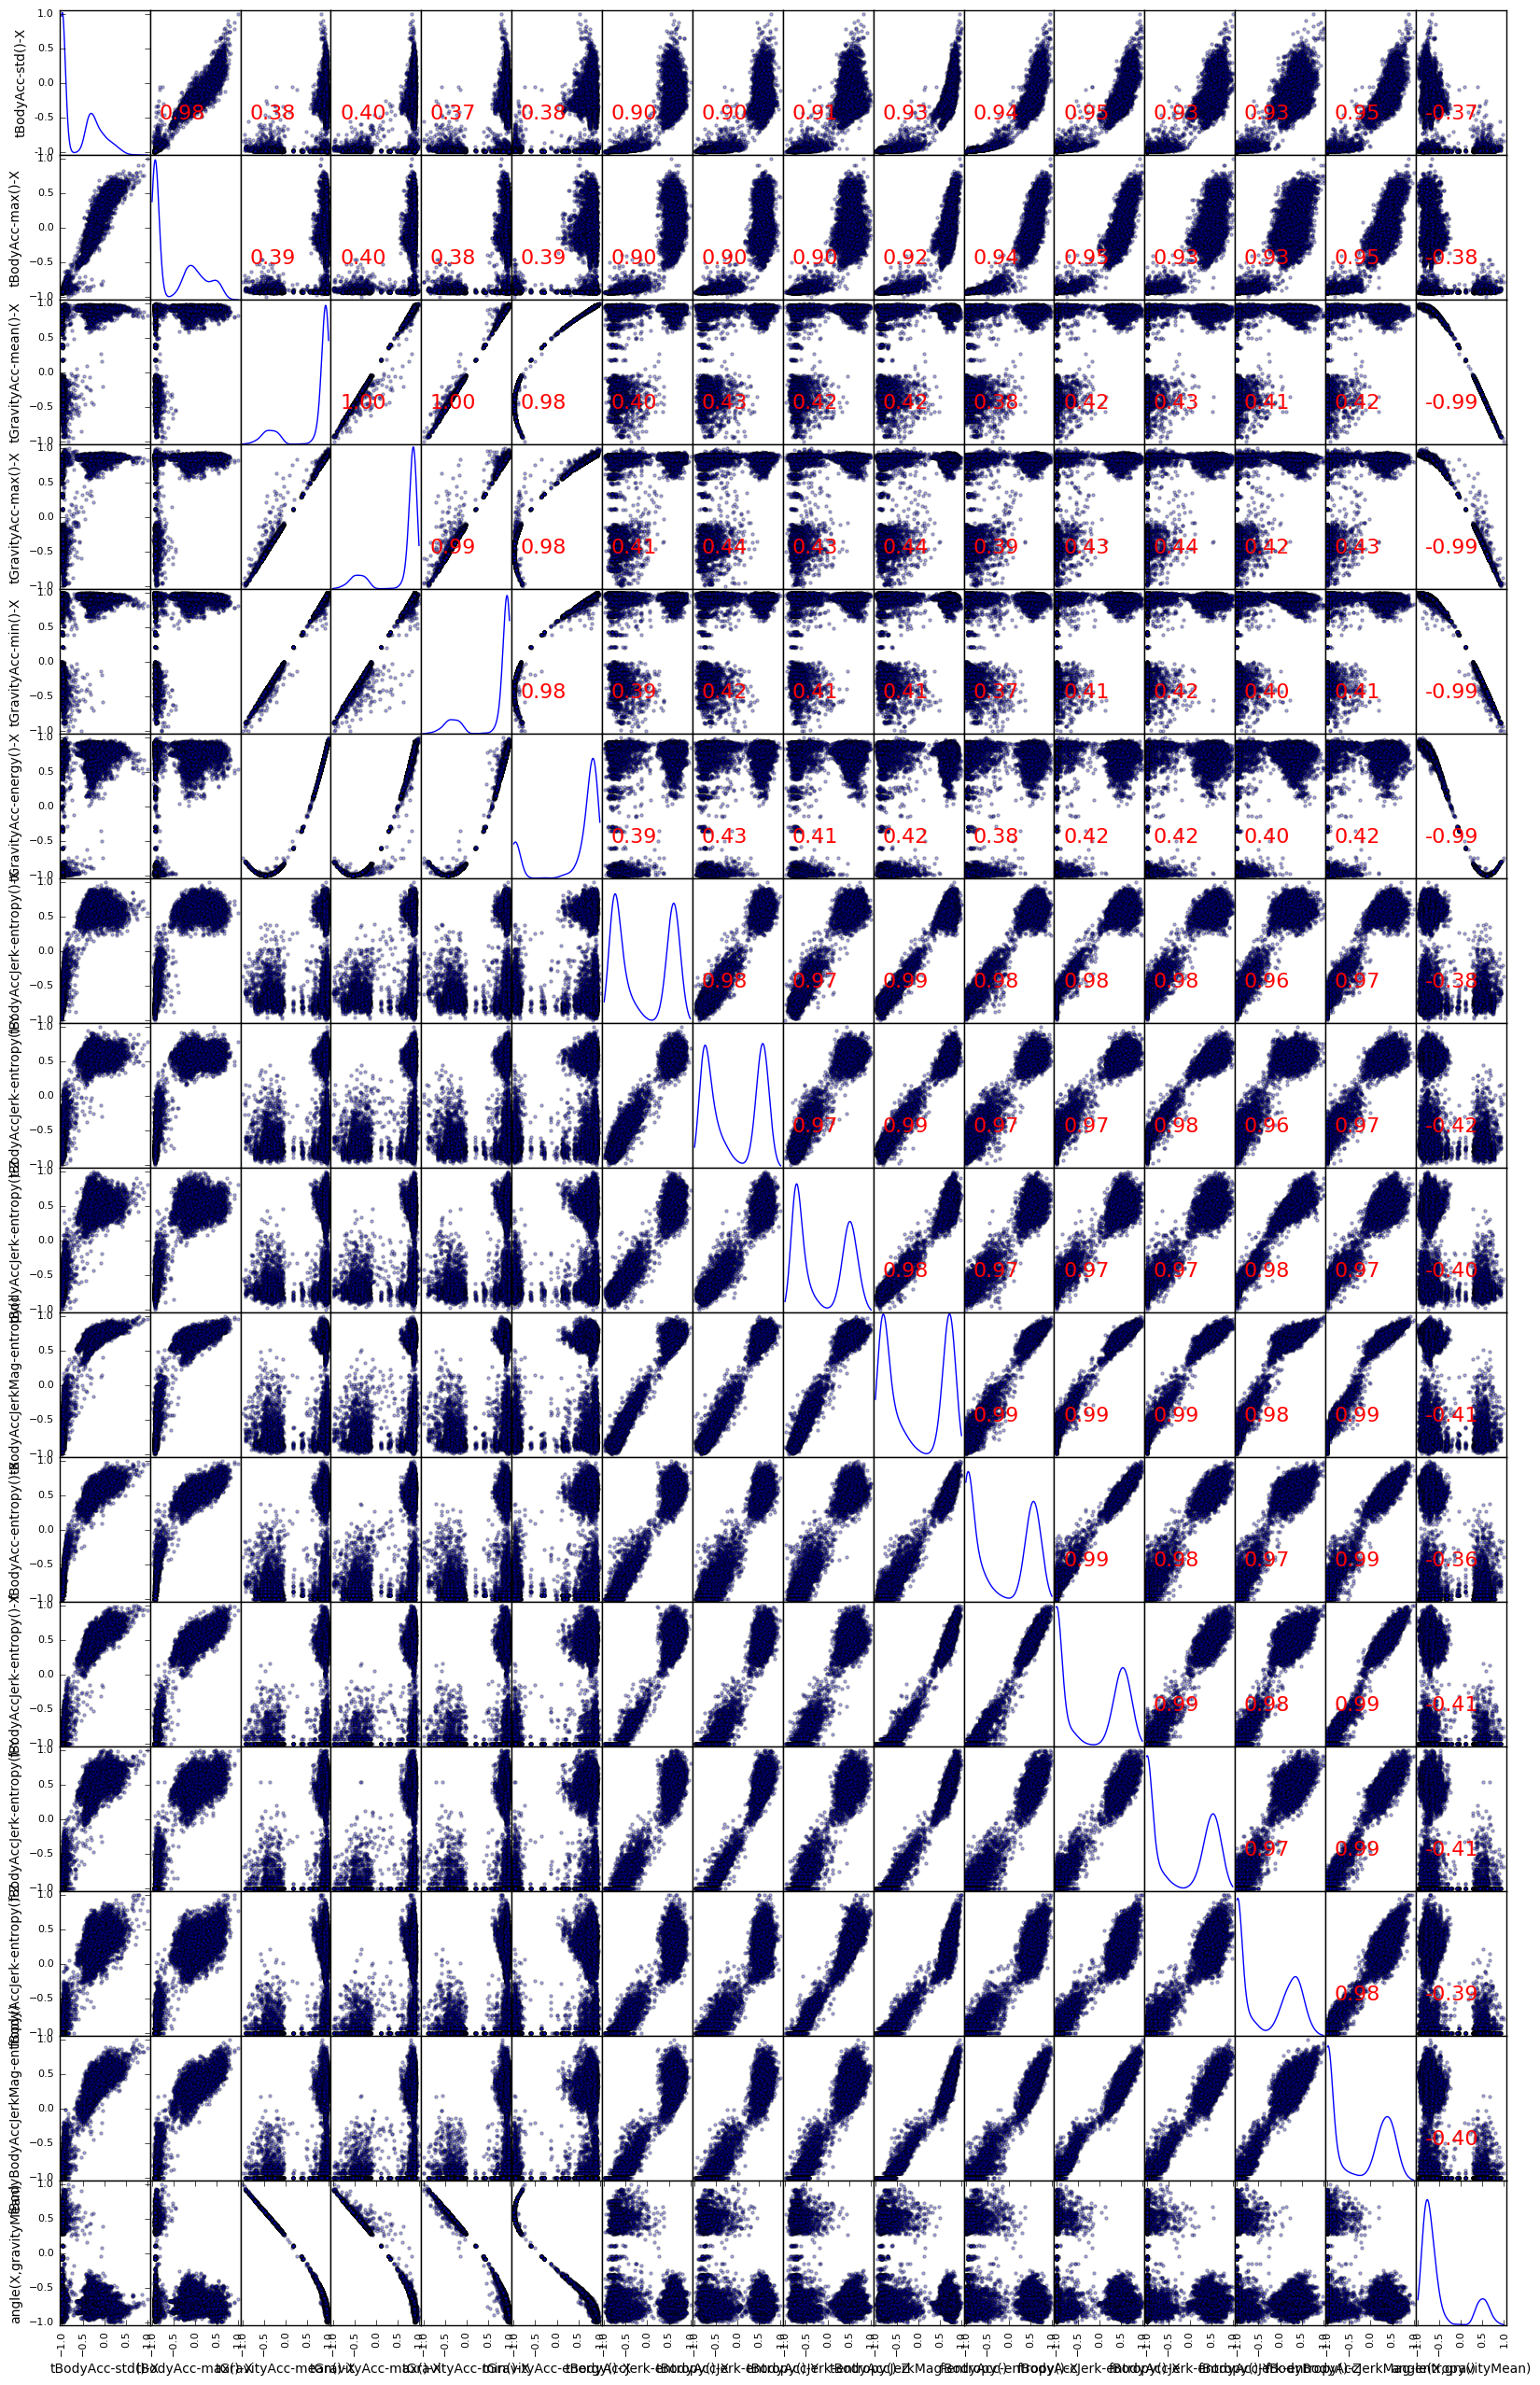

In [90]:
# Produce a scatter matrix for each pair of features in the data
axes = pd.scatter_matrix(Xs, alpha = 0.3, figsize = (20,32), diagonal = 'kde')

# Reformat data.corr() for plotting
corr = Xs.corr().as_matrix()

# Plot scatter matrix with correlations
for i,j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i,j].annotate("%.2f"%corr[i,j], (0.1,0.25), xycoords='axes fraction', color='red', fontsize=16)

Skewness greater than zero shows a positively skewed distribution, while lower than zero shows a negatively skewed distribution. Replacing the data with the log, square root, or inverse may help to remove the skew. However, feature values of the current dataset with selected features change between -1 and 1. Therefore, sqrt and log is not applicable. If we apply any of those transformations, most of the feature values will turn into NaN and dataset will be useless.

To avoid this we first shift data to a non-negative range, then apply the non-linear transformation, after that scale it back to -1 and 1 to be able to compare the change in the feature distribution with bare eyes. If all go right, we should be able to see less skewed feature distribution.

In addition to sqrt-ing and log-ing, I will also try boxcox-ing to reduce the skewness.

### Discussion 2 ###

SVM's classification performance for 16, 56, and 561 features are as follows:  
n_features: 16  t_train: 0.802sec  t_pred: 0.620sec  precision: 0.84 recall: 0.81  fscore: 0.79  
n_features: 56  t_train: 1.421sec  t_pred: 1.247sec  precision: 0.88  recall: 0.83  fscore: 0.81  
n_features: 561 t_train: 8.916sec  t_pred: 7.667sec  precision: 0.94 recall: 0.94  fscore: 0.94  

Using 16-feature reduced the training and testing time by more than 10 times while losing 10% classification performance measured as precision, recall and fscore. When compared to choosing 56 best features (top 10% of the whole feature vector), we see that 16-feature is almost as good as 56-feature in classification performance. 16-feature is twice faster than 56-feature in training and testing times.  

As 16-feature is good enough for SVM, now I will find ways to improve the classification performance by scaling, normalizing and outlier-removal. First, let's have a look at how the features are distributed by using a correlation matrix.

In [88]:
import scipy.stats.stats as st
skness = st.skew(Xs)

for skew, feature_name in zip(skness , Xs_cols.tolist()):
    print "skewness: {:+.2f}\t\t feature: ".format(skew) + feature_name

skewness: +0.64		 feature: tBodyAcc-std()-X
skewness: +0.60		 feature: tBodyAcc-max()-X
skewness: -1.63		 feature: tGravityAcc-mean()-X
skewness: -1.64		 feature: tGravityAcc-max()-X
skewness: -1.63		 feature: tGravityAcc-min()-X
skewness: -1.43		 feature: tGravityAcc-energy()-X
skewness: +0.11		 feature: tBodyAccJerk-entropy()-X
skewness: +0.07		 feature: tBodyAccJerk-entropy()-Y
skewness: +0.17		 feature: tBodyAccJerk-entropy()-Z
skewness: +0.08		 feature: tBodyAccJerkMag-entropy()
skewness: +0.13		 feature: fBodyAcc-entropy()-X
skewness: +0.20		 feature: fBodyAccJerk-entropy()-X
skewness: +0.19		 feature: fBodyAccJerk-entropy()-Y
skewness: +0.27		 feature: fBodyAccJerk-entropy()-Z
skewness: +0.23		 feature: fBodyBodyAccJerkMag-entropy()
skewness: +1.42		 feature: angle(X,gravityMean)


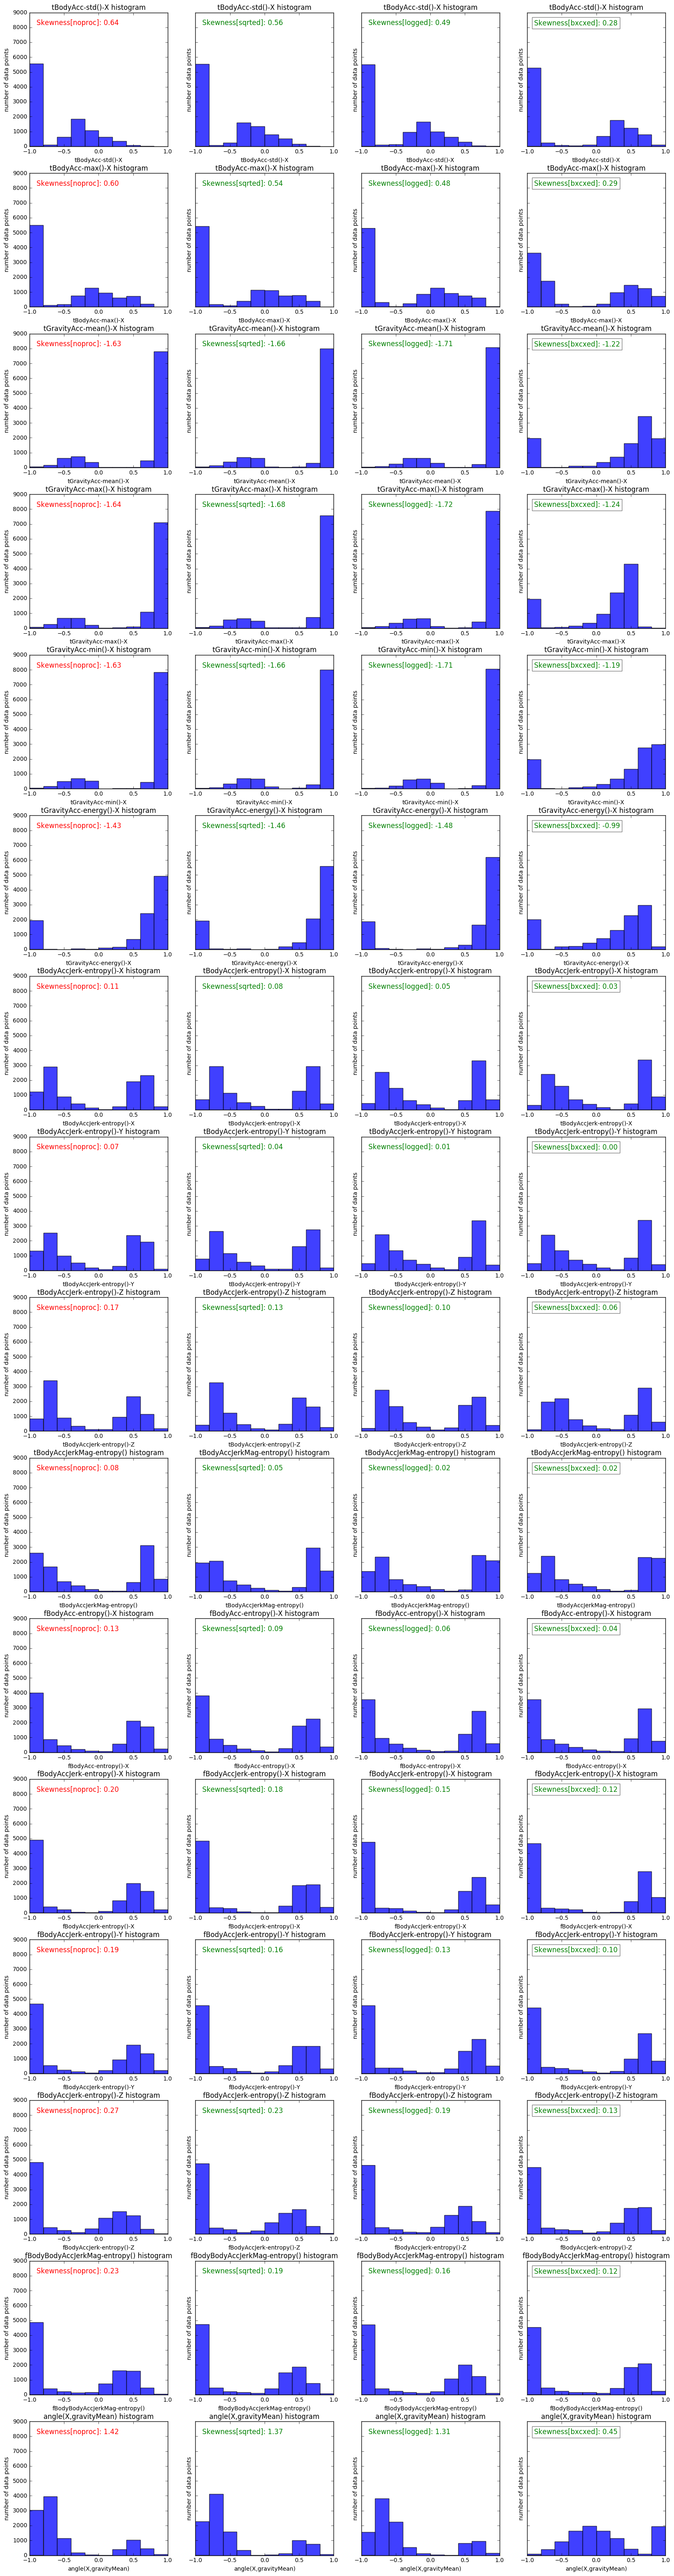

In [8]:
from sklearn import preprocessing
from scipy.stats import boxcox

plt.rcParams['figure.figsize'] = (20.0, 80.0)
f, axarr = plt.subplots(len(Xs_cols.tolist()), 4, sharey=True)

preprocessing_names = ["noproc", "sqrted", "logged", "bxcxed"]

cnt = 0
for feature in Xs_cols.tolist():
    
    for i in range(4):
#         axarr[cnt, i].set_title( "[" + preprocessing_names[i] + "] "+ feature)
        axarr[cnt, i].set_title(feature + " histogram")
        axarr[cnt, i].set_xlabel(feature)
        axarr[cnt, i].set_ylabel("number of data points")
    
    Xs_feature = Xs[feature]
    skness = st.skew(Xs_feature)
    axarr[cnt, 0].hist(Xs_feature,facecolor='blue',alpha=0.75)
    axarr[cnt, 0].text(0.05, 0.95, 'Skewness[noproc]: {:.2f}'.format(skness), transform=axarr[cnt, 0].transAxes, 
                       fontsize=12, verticalalignment='top', color='red')
    
    Xs_feature_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(Xs_feature)

    Xs_feature_sqrted = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(np.sqrt(Xs_feature_scaled))
#     Xs_feature_sqrted = preprocessing.scale(np.sqrt(Xs_feature_scaled))
    skness = st.skew(Xs_feature_sqrted)
    axarr[cnt, 1].hist(Xs_feature_sqrted,facecolor='blue',alpha=0.75)
    axarr[cnt, 1].text(0.05, 0.95, 'Skewness[sqrted]: {:.2f}'.format(skness), transform=axarr[cnt, 1].transAxes, 
                       fontsize=12, verticalalignment='top', color='green')
    
    Xs_feature_logged = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(np.log(Xs_feature_scaled))
#     Xs_feature_logged = preprocessing.scale(np.log(Xs_feature_scaled))
    skness = st.skew(Xs_feature_logged)
    axarr[cnt, 2].hist(Xs_feature_logged,facecolor='blue',alpha=0.75)
    axarr[cnt, 2].text(0.05, 0.95, 'Skewness[logged]: {:.2f}'.format(skness), transform=axarr[cnt, 2].transAxes, 
                       fontsize=12, verticalalignment='top', color='green')
    
    Xs_feature_bxcxed = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(boxcox(Xs_feature_scaled)[0])
#     Xs_feature_bxcxed = preprocessing.scale(boxcox(Xs_feature_scaled)[0])
    skness = st.skew(Xs_feature_bxcxed)
    axarr[cnt, 3].hist(Xs_feature_bxcxed,facecolor='blue',alpha=0.75)
    axarr[cnt, 3].text(0.05, 0.95, 'Skewness[bxcxed]: {:.2f}'.format(skness), transform=axarr[cnt, 3].transAxes, fontsize=12, 
                       verticalalignment='top', color='green',  bbox=dict(facecolor='white', alpha=0.5, boxstyle='square'))    
    cnt += 1

plt.show()

Tried robust scaler but it didn't have any effect on the dataset's skewness

In [9]:
Xs_rscaled = preprocessing.RobustScaler().fit_transform(Xs)
print Xs_rscaled.shape

for feature in range(Xs_rscaled.shape[1]):
    Xs_rscaled_feature = Xs_rscaled[:,feature]
    skness = st.skew(Xs_rscaled_feature)
    print "{:2d}".format(feature) + "  {:+.2f}".format(skness)

(10299L, 16L)
 0  +0.64
 1  +0.60
 2  -1.63
 3  -1.64
 4  -1.63
 5  -1.43
 6  +0.11
 7  +0.07
 8  +0.17
 9  +0.08
10  +0.13
11  +0.20
12  +0.19
13  +0.27
14  +0.23
15  +1.42


In [10]:
def ScaleData(data):
    data_scaled = []
    for feature in range(data.shape[1]):
        data_scaled_feature = preprocessing.scale(data[:,feature])
        if feature == 0:
            data_scaled = data_scaled_feature
        else:
            data_scaled = np.column_stack([data_scaled, data_scaled_feature])
    return data_scaled

def testSVMPerformance(data_train, label_train, data_test, label_test, preprocess_method):
    
    if preprocess_method != "":
        data_train = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(data_train)
        data_test = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(data_test)
    
        if preprocess_method == "logged":
            data_train = np.log(data_train)
            data_test = np.log(data_test)
        elif preprocess_method == "sqrted":
            data_train = np.sqrt(data_train)
            data_test = np.sqrt(data_test)
        elif preprocess_method == "bxcxed":
            data_train = boxCoxData(data_train)
            data_test = boxCoxData(data_test)
            
        #this resulted in a more inferior performance compared to preprocessing.scale method
#         data_train = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(data_train)
#         data_test = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(data_test)

        data_train = ScaleData(data_train)
        data_test = ScaleData(data_test)        
        
    start = time()
    clf_SVM.fit(data_train, label_train)
    end = time()
    t_train = end - start
    #NOTE: For some reason this doesn't work here
#     t_train = train(clf_SVM, data_train, label_train)
    t_test, y_pred = predict(clf_SVM, data_test)
    precision, recall, fscore, support = precision_recall_fscore_support(label_test, y_pred, average='weighted')

    printout = preprocess_method
    if preprocess_method == "":
        printout = "noproc"
    
    printout += "  t_train: {:.3f}sec".format(t_train)
    printout += "  t_pred: {:.3f}sec".format(t_test)
    printout += "  precision: {:.2f}".format(precision)
    printout += "  recall: {:.2f}".format(recall)
    printout += "  fscore: {:.2f}".format(fscore)
    print printout

X_train_processed = X_train[Xs_cols]
X_test_processed = X_test[Xs_cols]

testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "scaled")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "logged")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "sqrted")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "bxcxed")

noproc  t_train: 0.808sec  t_pred: 0.621sec  precision: 0.84  recall: 0.81  fscore: 0.79
scaled  t_train: 0.715sec  t_pred: 0.549sec  precision: 0.85  recall: 0.82  fscore: 0.81
logged  t_train: 0.733sec  t_pred: 0.594sec  precision: 0.84  recall: 0.82  fscore: 0.82
sqrted  t_train: 0.713sec  t_pred: 0.555sec  precision: 0.84  recall: 0.82  fscore: 0.82
bxcxed  t_train: 0.649sec  t_pred: 0.538sec  precision: 0.87  recall: 0.87  fscore: 0.87


It is time to test if there is any outlier in the boxcoxed dataset.

In [11]:
Xs_processed = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(Xs)
Xs_bxcxed = boxCoxData(Xs_processed)
Xs_bxcxed_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(Xs_bxcxed)

outliers = []
for feature in range(Xs_bxcxed_scaled.shape[1]):
    Q1 = np.percentile(Xs_bxcxed_scaled[:, feature], 25)
    Q3 = np.percentile(Xs_bxcxed_scaled[:, feature], 75)
    step = 1.5 * (Q3 - Q1)

    outlier_filter = ~((Xs_bxcxed_scaled[:, feature] >= Q1 - step) & (Xs_bxcxed_scaled[:, feature] <= Q3 + step))
    
    cnt = 0
    for outlier in outlier_filter:
        if outlier:
            outliers.append(cnt)
        cnt += 1
    
# print "number of outliers with repeating indices: " + str(len(outliers))

id2cnt = {}
for outlier in outliers:
    if not outlier in id2cnt:
        id2cnt[outlier] = 1
    else:
        id2cnt[outlier] += 1
    
sorted_id2cnt = sorted(id2cnt.items(), key=operator.itemgetter(1), reverse=True)
cnt2nindices = {}
for key, value in sorted_id2cnt:
    #only remove the outliers that are repeated more than once
    if value <=1:
        break
    if not value in cnt2nindices:
        cnt2nindices[value] = 1
    else:
        cnt2nindices[value] += 1

for key, value in cnt2nindices.iteritems():
    print "{:2d} features share {:4d} potential outliers".format(key, value)

 2 features share   23 potential outliers
 3 features share 1953 potential outliers


Let's try to remove those 1953 potential outliers and test the performance of the SVM again. Although, this seems like losing too much data, I just want to see how this may effect the learning performance.

In [12]:
removed_outliers = []
for key, value in sorted_id2cnt:
    if value == 3:
        removed_outliers.append(key)

y_labels = y['Activity']

results_precision = []
results_recall = []
results_fscore = []
kfold = cross_validation.KFold(Xs.shape[0], n_folds=10, shuffle=False, random_state=42)
for train, test in kfold:
    clf_SVM.fit(Xs.iloc[train], y_labels.iloc[train])
#         t_train = train(clf_SVM, Xs_subset.iloc[train], y_subset.iloc[train])
    t_test, y_pred = predict(clf_SVM, Xs.iloc[test])
    precision, recall, fscore, support = precision_recall_fscore_support(y_labels.iloc[test], y_pred, 
                                                                         average='weighted')
    results_precision.append(precision)
    results_recall.append(recall)
    results_fscore.append(fscore)

printout = "subsetsize: {:5d}".format(Xs.shape[0])
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
printout += "  precision: {:.2f}".format(np.mean(results_precision))
printout += "  recall: {:.2f}".format(np.mean(results_recall))
printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
print printout

Xs_filtered = Xs.drop(removed_outliers)
y_filtered = y.drop(removed_outliers)
y_filtered_labels = y_filtered['Activity'].to_frame()

Xs_filtered_proc = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(Xs_filtered)
Xs_filtered_proc = boxCoxData(Xs_filtered_proc)
Xs_filtered_proc = ScaleData(Xs_filtered_proc)
Xs_filtered_proc = Xs_filtered_proc

results_precision = []
results_recall = []
results_fscore = []
kfold = cross_validation.KFold(Xs_filtered_proc.shape[0], n_folds=10, shuffle=False, random_state=42)  
for train, test in kfold:
    clf_SVM.fit(Xs_filtered_proc[train], y_filtered_labels.iloc[train])
    t_test, y_pred = predict(clf_SVM, Xs_filtered_proc[test])
    precision, recall, fscore, support = precision_recall_fscore_support(y_filtered_labels.iloc[test], y_pred, 
                                                                         average='weighted')
    results_precision.append(precision)
    results_recall.append(recall)
    results_fscore.append(fscore)

print "**************"
printout = "subsetsize: {:5d}".format(Xs_filtered_proc.shape[0])
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
printout += "  precision: {:.2f}".format(np.mean(results_precision))
printout += "  recall: {:.2f}".format(np.mean(results_recall))
printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
print printout


results_precision = []
results_recall = []
results_fscore = []
kfold = cross_validation.KFold(Xs_filtered.shape[0], n_folds=10, shuffle=False, random_state=42)  
for train, test in kfold:
    clf_SVM.fit(Xs_filtered.iloc[train], y_filtered_labels.iloc[train])
#         t_train = train(clf_SVM, Xs_subset.iloc[train], y_subset.iloc[train])
    t_test, y_pred = predict(clf_SVM, Xs_filtered.iloc[test])
    precision, recall, fscore, support = precision_recall_fscore_support(y_filtered_labels.iloc[test], y_pred, 
                                                                         average='weighted')
    results_precision.append(precision)
    results_recall.append(recall)
    results_fscore.append(fscore)

printout = "subsetsize: {:5d}".format(Xs_filtered.shape[0])
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
printout += "  precision: {:.2f}".format(np.mean(results_precision))
printout += "  recall: {:.2f}".format(np.mean(results_recall))
printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
print printout

from random import sample
n_multiplier = Xs.shape[0]/500

for i in range(1, n_multiplier+1):
    subsetsize = i*500
    random_index = sample(range(0, Xs.shape[0]), subsetsize)
    
    Xs_subset = Xs.iloc[random_index]
    y_subset = y_labels.iloc[random_index].to_frame()

    results_precision = []
    results_recall = []
    results_fscore = []
    kfold = cross_validation.KFold(Xs_subset.shape[0], n_folds=10, shuffle=False, random_state=42)
    for train, test in kfold:
        clf_SVM.fit(Xs_subset.iloc[train], y_subset.iloc[train])
#         t_train = train(clf_SVM, Xs_subset.iloc[train], y_subset.iloc[train])
        t_test, y_pred = predict(clf_SVM, Xs_subset.iloc[test])
        precision, recall, fscore, support = precision_recall_fscore_support(y_subset.iloc[test], y_pred, 
                                                                             average='weighted')
        results_precision.append(precision)
        results_recall.append(recall)
        results_fscore.append(fscore)

    printout = "subsetsize: {:5d}".format(subsetsize)
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
    printout += "  precision: {:.2f}".format(np.mean(results_precision))
    printout += "  recall: {:.2f}".format(np.mean(results_recall))
    printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
    print printout

subsetsize: 10299  precision: 0.85  recall: 0.82  fscore: 0.81
**************
subsetsize:  8346  precision: 0.88  recall: 0.87  fscore: 0.87
subsetsize:  8346  precision: 0.82  recall: 0.78  fscore: 0.76
subsetsize:   500  precision: 0.81  recall: 0.77  fscore: 0.74
subsetsize:  1000  precision: 0.85  recall: 0.79  fscore: 0.76
subsetsize:  1500  precision: 0.82  recall: 0.80  fscore: 0.79
subsetsize:  2000  precision: 0.81  recall: 0.79  fscore: 0.79
subsetsize:  2500  precision: 0.85  recall: 0.80  fscore: 0.77
subsetsize:  3000  precision: 0.84  recall: 0.81  fscore: 0.80
subsetsize:  3500  precision: 0.86  recall: 0.82  fscore: 0.79
subsetsize:  4000  precision: 0.85  recall: 0.82  fscore: 0.81
subsetsize:  4500  precision: 0.85  recall: 0.82  fscore: 0.81
subsetsize:  5000  precision: 0.85  recall: 0.83  fscore: 0.81
subsetsize:  5500  precision: 0.85  recall: 0.82  fscore: 0.80
subsetsize:  6000  precision: 0.86  recall: 0.83  fscore: 0.81
subsetsize:  6500  precision: 0.85  reca

This shows that feature preprocessing and outlier removal are tied together. In other words, detected outliers are special to the space they are transformed to through preprocessing methods. Therefore, outliers in transformed space may not be outliers in the original space. Following results show that removing the outliers is only good if the learning is done on the space where those features transformed to.  

subsetsize:  8346  precision: 0.87  recall: 0.86  fscore: 0.86 (features are preprocessed)  
subsetsize:  8346  precision: 0.80  recall: 0.76  fscore: 0.74 (features are kept as the way they are)  

In [91]:
from sklearn.decomposition import PCA

num_components = range(2, X.shape[1]/10, 2) + range(X.shape[1]/10, X.shape[1]/3, X.shape[1]/40)

d_npca = {}
for n_components in num_components:
    pca = PCA(n_components=n_components).fit(X)
#     print pca.explained_variance_ratio_
    printout = "n_components: {:d}".format(n_components)
    X_pcaed = pca.transform(X)
    
    dimensions = []
    for i in range(0, n_components):
        dimensions.append("comp_{:3d}".format(i))
    
    X_pcaed_df = pd.DataFrame(X_pcaed, columns = dimensions)

    print "SVM npca={:3d}".format(n_components),
    results = GetClassificationPerformance(clf_SVM, X_pcaed_df, y["Activity"].to_frame(), 10, "")
    d_npca[n_components] = results

# d_ncpa_to_precision = {}
# d_npca_to_recall = {}
# d_npca_to_f1score = {}

# for n_components in num_components:
#     pca = PCA(n_components=n_components).fit(X)
# #     print pca.explained_variance_ratio_
#     printout = "n_components: {:d}".format(n_components)
#     X_pcaed = pca.transform(X)
    
#     results_precision = []
#     results_recall = []
#     results_fscore = []    
#     kfold = cross_validation.KFold(X_pcaed.shape[0], n_folds=10, shuffle=False, random_state=42)
#     for train, test in kfold:
#         clf_SVM.fit(X_pcaed[train], y_[train])
#         t_test, y_pred = predict(clf_SVM, X_pcaed[test])
#         precision, recall, fscore, support = precision_recall_fscore_support(y_[test], y_pred, 
#                                                                              average='weighted')
#         results_precision.append(precision)
#         results_recall.append(recall)
#         results_fscore.append(fscore)

#     printout += "  precision: {:.2f}".format(np.mean(results_precision))
#     printout += "  recall: {:.2f}".format(np.mean(results_recall))
#     printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
#     print printout

#     d_ncpa_to_precision[n_components]=np.mean(results_precision)
#     d_npca_to_recall[n_components]=np.mean(results_recall)
#     d_npca_to_f1score[n_components]=np.mean(results_fscore)    

SVM npca=  2   precision: 0.64  recall: 0.63  fscore: 0.61    t_train: 2.30 t_test: 0.25
SVM npca=  4   precision: 0.80  recall: 0.78  fscore: 0.77    t_train: 1.16 t_test: 0.17
SVM npca=  6   precision: 0.84  recall: 0.83  fscore: 0.82    t_train: 1.00 t_test: 0.15
SVM npca=  8   precision: 0.86  recall: 0.85  fscore: 0.85    t_train: 0.87 t_test: 0.14
SVM npca= 10   precision: 0.88  recall: 0.88  fscore: 0.88    t_train: 0.85 t_test: 0.14
SVM npca= 12   precision: 0.89  recall: 0.88  fscore: 0.88    t_train: 0.86 t_test: 0.14
SVM npca= 14   precision: 0.90  recall: 0.89  fscore: 0.89    t_train: 0.87 t_test: 0.15
SVM npca= 16   precision: 0.91  recall: 0.90  fscore: 0.90    t_train: 0.86 t_test: 0.15
SVM npca= 18   precision: 0.91  recall: 0.90  fscore: 0.90    t_train: 0.89 t_test: 0.16
SVM npca= 20   precision: 0.91  recall: 0.90  fscore: 0.90    t_train: 0.91 t_test: 0.17
SVM npca= 22   precision: 0.92  recall: 0.91  fscore: 0.91    t_train: 0.89 t_test: 0.16
SVM npca= 24   precis

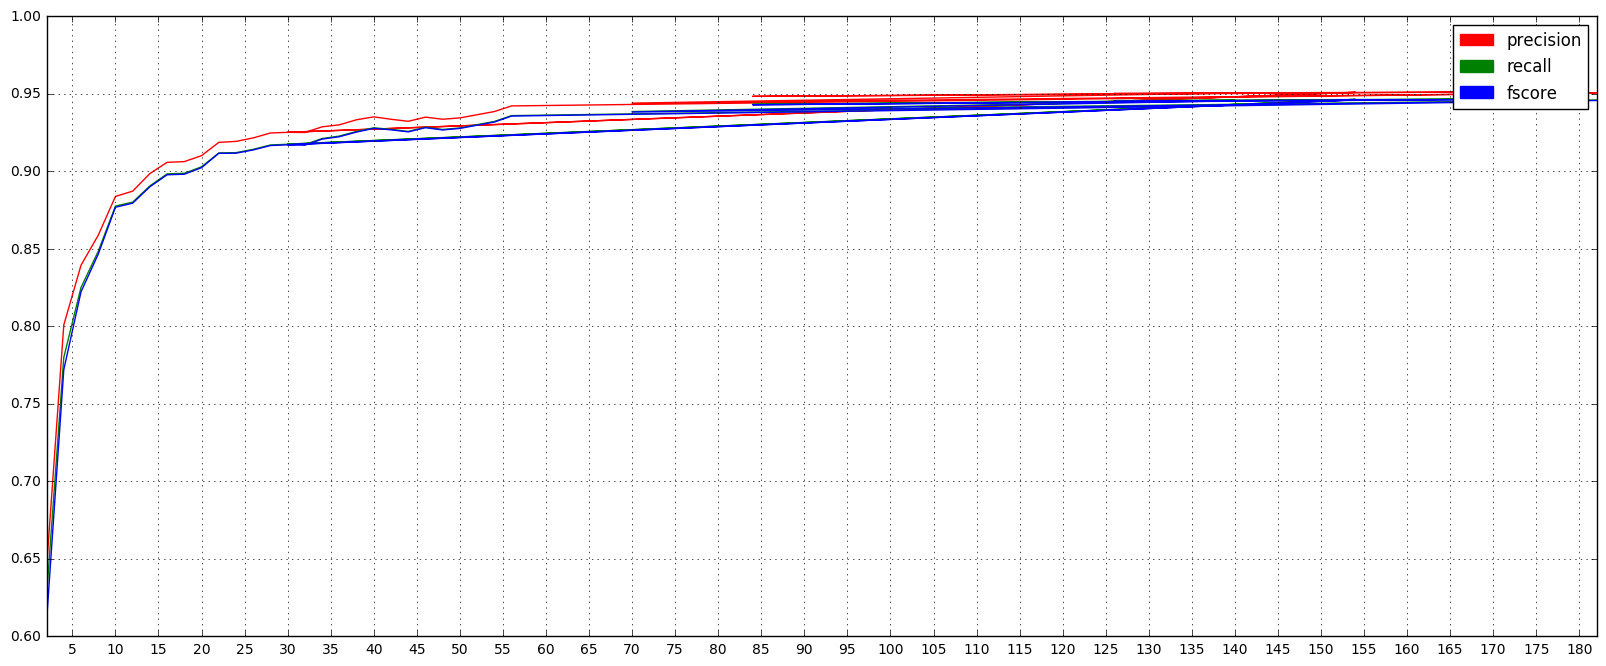

In [93]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.grid(True)

major_ticks = np.arange(0, X.shape[1]/3, 20) 
minor_ticks = np.arange(0, X.shape[1]/3, 5)

d_npca2precision = {}
d_npca2recall = {}
d_npca2fscore = {}
d_npca2ttrain = {}
d_npca2ttest = {}

for key, value in d_npca.iteritems():
    d_npca2precision[key] = value[0]
    d_npca2recall[key] = value[1]
    d_npca2fscore[key] = value[2]
    d_npca2ttrain[key] = value[3]
    d_npca2ttest[key] = value[4]

plt.xticks(minor_ticks)
plt.plot(d_npca2precision.keys(), d_npca2precision.values(), 'r',
        d_npca2recall.keys(), d_npca2recall.values(), 'g',
        d_npca2fscore.keys(), d_npca2fscore.values(), 'b')

import matplotlib.patches as mpatches
r_patch = mpatches.Patch(color='red', label='precision')
g_patch = mpatches.Patch(color='green', label='recall')
b_patch = mpatches.Patch(color='blue', label='fscore')

plt.legend(handles=[r_patch, g_patch, b_patch])
plt.show()

In [103]:
from sklearn.decomposition import PCA

num_components = range(112, 140)

d_npca = {}
for n_components in num_components:
    pca = PCA(n_components=n_components).fit(X)
#     print pca.explained_variance_ratio_
    printout = "n_components: {:d}".format(n_components)
    X_pcaed = pca.transform(X)
    
    dimensions = []
    for i in range(0, n_components):
        dimensions.append("comp_{:3d}".format(i))
    
    X_pcaed_df = pd.DataFrame(X_pcaed, columns = dimensions)

    print "SVM npca={:3d}".format(n_components),
    results = GetClassificationPerformance(clf_SVM, X_pcaed_df, y["Activity"].to_frame(), 10, "")
    d_npca[n_components] = results

SVM npca=112  precision:0.95 recall:0.94 fscore:0.94   t_train:1.47 t_test:0.35
SVM npca=113  precision:0.95 recall:0.94 fscore:0.94   t_train:1.50 t_test:0.35
SVM npca=114  precision:0.95 recall:0.94 fscore:0.94   t_train:1.54 t_test:0.36
SVM npca=115  precision:0.95 recall:0.94 fscore:0.94   t_train:1.51 t_test:0.36
SVM npca=116  precision:0.95 recall:0.95 fscore:0.94   t_train:1.51 t_test:0.36
SVM npca=117  precision:0.95 recall:0.95 fscore:0.95   t_train:1.52 t_test:0.36
SVM npca=118  precision:0.95 recall:0.95 fscore:0.95   t_train:1.53 t_test:0.36
SVM npca=119  precision:0.95 recall:0.95 fscore:0.95   t_train:1.55 t_test:0.37
SVM npca=120  precision:0.95 recall:0.95 fscore:0.95   t_train:1.56 t_test:0.37
SVM npca=121  precision:0.95 recall:0.95 fscore:0.95   t_train:1.58 t_test:0.37
SVM npca=122  precision:0.95 recall:0.95 fscore:0.95   t_train:1.60 t_test:0.38
SVM npca=123  precision:0.95 recall:0.95 fscore:0.95   t_train:1.61 t_test:0.38
SVM npca=124  precision:0.95 recall:0.95

In [94]:
X_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(X)
X_bxcxed = boxCoxData(X_scaled)
X_bxcxed_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(X_bxcxed)

num_components = range(2, X.shape[1]/10, 2) + range(X.shape[1]/10, X.shape[1]/3, X.shape[1]/40)

d_npca = {}
for n_components in num_components:
    pca = PCA(n_components=n_components).fit(X_bxcxed_scaled)
#     print pca.explained_variance_ratio_
    printout = "n_components: {:d}".format(n_components)
    X_pcaed = pca.transform(X_bxcxed_scaled)
    
    dimensions = []
    for i in range(0, n_components):
        dimensions.append("comp_{:3d}".format(i))
    
    X_pcaed_df = pd.DataFrame(X_pcaed, columns = dimensions)

    print "SVM npca={:3d}".format(n_components),
    results = GetClassificationPerformance(clf_SVM, X_pcaed_df, y["Activity"].to_frame(), 10, "")
    d_npca[n_components] = results

SVM npca=  2   precision: 0.60  recall: 0.58  fscore: 0.57    t_train: 3.06 t_test: 0.27
SVM npca=  4   precision: 0.77  recall: 0.75  fscore: 0.74    t_train: 1.71 t_test: 0.19
SVM npca=  6   precision: 0.82  recall: 0.81  fscore: 0.80    t_train: 1.71 t_test: 0.19
SVM npca=  8   precision: 0.85  recall: 0.84  fscore: 0.84    t_train: 1.57 t_test: 0.17
SVM npca= 10   precision: 0.87  recall: 0.86  fscore: 0.86    t_train: 1.47 t_test: 0.17
SVM npca= 12   precision: 0.88  recall: 0.87  fscore: 0.87    t_train: 1.40 t_test: 0.17
SVM npca= 14   precision: 0.89  recall: 0.88  fscore: 0.88    t_train: 1.42 t_test: 0.18
SVM npca= 16   precision: 0.89  recall: 0.89  fscore: 0.88    t_train: 1.45 t_test: 0.19
SVM npca= 18   precision: 0.90  recall: 0.89  fscore: 0.89    t_train: 1.44 t_test: 0.20
SVM npca= 20   precision: 0.91  recall: 0.90  fscore: 0.90    t_train: 1.45 t_test: 0.20
SVM npca= 22   precision: 0.91  recall: 0.91  fscore: 0.90    t_train: 1.45 t_test: 0.20
SVM npca= 24   precis

In [75]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (18,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

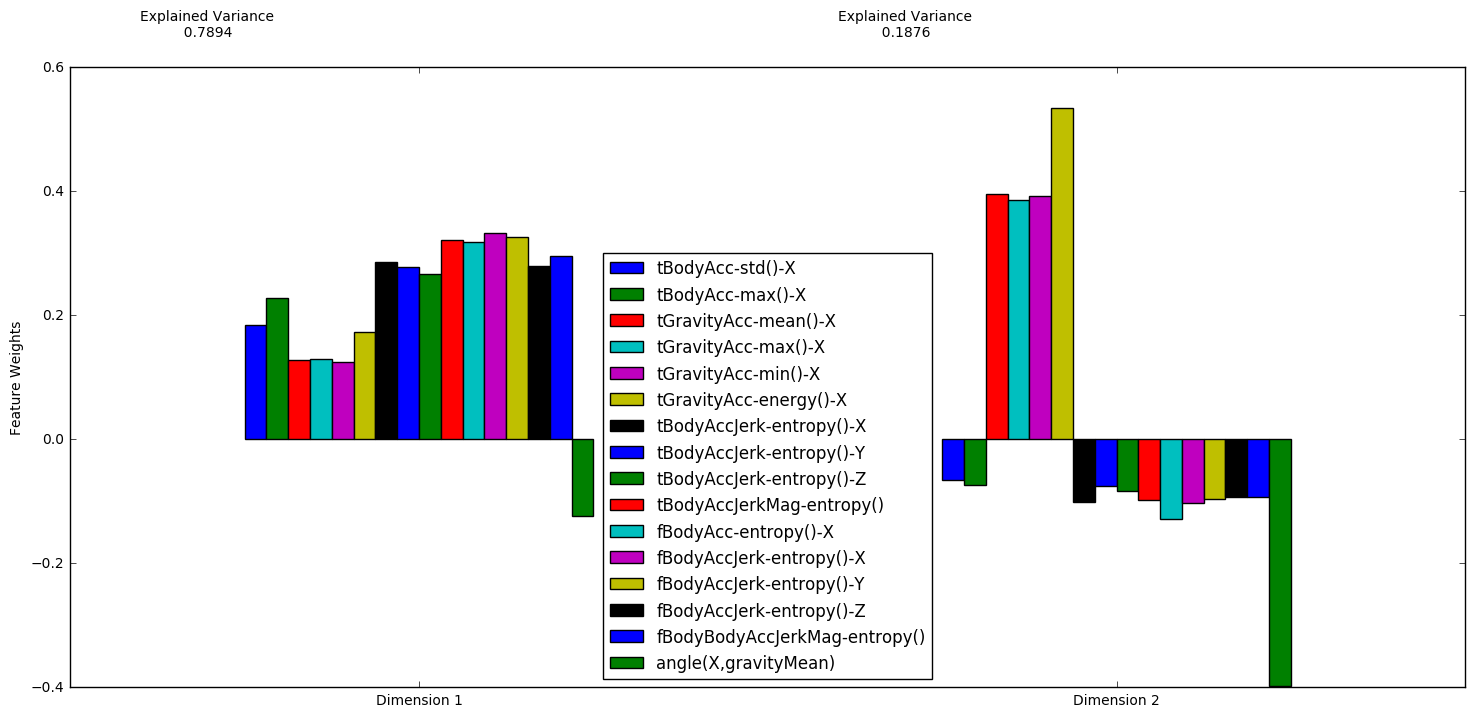

In [76]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components).fit(Xs)
# print pca.components_
# print pca.explained_variance_ratio_
# print pca_results['Explained Variance'].cumsum()
pca_results = pca_results(Xs, pca)

# # TODO: Transform the good data using the PCA fit above
# Xs_pcaed = pca.transform(Xs)
# print Xs.shape
# print Xs_pcaed.shape

# # Create a DataFrame for the reduced data
# Xs_pcaed = pd.DataFrame(Xs_pcaed, columns = ['Dimension 1', 'Dimension 2'])
# print Xs_pcaed.shape

# # Produce a scatter matrix for pca reduced data
# pd.scatter_matrix(Xs_pcaed, alpha = 0.8, figsize = (8,4), diagonal = 'kde');

# components = pd.DataFrame(np.round(pca.components_, 4), columns = Xs.keys())
# print components

In [230]:
d_nmiss2precision = {}
d_nmiss2recall = {}
d_nmiss2fscore = {}
d_nmiss2ttrain = {}
d_nmiss2ttest = {}
d_nmiss2tproc = {}

min_num_indices = X.shape[0]/100
max_num_indices = X.shape[0]/2

clf_SVM = SVC(C=100, kernel='rbf', gamma=0.001, class_weight='balanced')

for num_indices in range(min_num_indices, max_num_indices, min_num_indices):
    Xc = X.copy(deep=True)
    row_indices = sample(range(0, Xc.shape[0]), num_indices)
    col_indices = sample(range(0, Xc.shape[1]), Xc.shape[1]/2) # 1/4th of the feature vector is corrupted
    col_names = Xc.columns[col_indices]
    
    for row in row_indices:
            Xc.iloc[row, col_indices]= np.nan
    
    for col in col_names:
        Xc[col].fillna(Xc[col].mean(), inplace=True)

    #create pca features
    Xc_df, times = CreateFeatureSet(Xc, 0, 117)
    print "SVM PCAed:{:3d} n_id:{:4d}".format(117, num_indices),
    results = GetClassificationPerformance(clf_SVM, Xc, y["Activity"].to_frame(), 10, "")
    d_nmiss2precision[num_indices]=results[0]
    d_nmiss2recall[num_indices]=results[1]
    d_nmiss2fscore[num_indices]=results[2]
    d_nmiss2ttrain[num_indices]=results[3]
    d_nmiss2ttest[num_indices]=results[4]
    d_nmiss2tproc[num_indices]=times[2]

SVM PCAed:117 n_id: 102  precision:0.96 recall:0.96 fscore:0.96   t_train:4.41 t_test:0.96
SVM PCAed:117 n_id: 204  precision:0.96 recall:0.96 fscore:0.96   t_train:4.45 t_test:0.97
SVM PCAed:117 n_id: 306  precision:0.96 recall:0.96 fscore:0.96   t_train:4.56 t_test:1.01
SVM PCAed:117 n_id: 408  precision:0.96 recall:0.96 fscore:0.96   t_train:4.49 t_test:0.98
SVM PCAed:117 n_id: 510  precision:0.96 recall:0.96 fscore:0.96   t_train:4.48 t_test:0.98
SVM PCAed:117 n_id: 612  precision:0.96 recall:0.96 fscore:0.96   t_train:4.46 t_test:0.97
SVM PCAed:117 n_id: 714  precision:0.96 recall:0.96 fscore:0.96   t_train:4.49 t_test:0.99
SVM PCAed:117 n_id: 816  precision:0.96 recall:0.96 fscore:0.96   t_train:4.66 t_test:1.03
SVM PCAed:117 n_id: 918  precision:0.96 recall:0.96 fscore:0.96   t_train:4.52 t_test:1.00
SVM PCAed:117 n_id:1020  precision:0.96 recall:0.96 fscore:0.96   t_train:4.54 t_test:0.98
SVM PCAed:117 n_id:1122  precision:0.96 recall:0.96 fscore:0.96   t_train:4.81 t_test:1.04

In [232]:
d_nmiss22precision = {}
d_nmiss22recall = {}
d_nmiss22fscore = {}
d_nmiss22ttrain = {}
d_nmiss22ttest = {}
d_nmiss22tproc = {}

min_num_indices = X.shape[0]/100
max_num_indices = X.shape[0]/2

clf = SGDClassifier()

for num_indices in range(min_num_indices, max_num_indices, min_num_indices):
    Xc = X.copy(deep=True)
    row_indices = sample(range(0, Xc.shape[0]), num_indices)
    col_indices = sample(range(0, Xc.shape[1]), Xc.shape[1]/2) # 1/4th of the feature vector is corrupted
    col_names = Xc.columns[col_indices]
    
    for row in row_indices:
            Xc.iloc[row, col_indices]= np.nan
    
    for col in col_names:
        Xc[col].fillna(Xc[col].mean(), inplace=True)

    #create pca features
    Xc_df, times = CreateFeatureSet(Xc, 0, 117)
    print "SVM PCAed:{:3d} n_id:{:4d}".format(117, num_indices),
    results = GetClassificationPerformance(clf, Xc, y["Activity"].to_frame(), 10, "")
    d_nmiss22precision[num_indices]=results[0]
    d_nmiss22recall[num_indices]=results[1]
    d_nmiss22fscore[num_indices]=results[2]
    d_nmiss22ttrain[num_indices]=results[3]
    d_nmiss22ttest[num_indices]=results[4]
    d_nmiss22tproc[num_indices]=times[2]

SVM PCAed:117 n_id: 102  precision:0.93 recall:0.91 fscore:0.91   t_train:0.38 t_test:0.01
SVM PCAed:117 n_id: 204  precision:0.94 recall:0.93 fscore:0.93   t_train:0.37 t_test:0.01
SVM PCAed:117 n_id: 306  precision:0.94 recall:0.93 fscore:0.93   t_train:0.34 t_test:0.01
SVM PCAed:117 n_id: 408  precision:0.94 recall:0.92 fscore:0.92   t_train:0.35 t_test:0.01
SVM PCAed:117 n_id: 510  precision:0.94 recall:0.93 fscore:0.93   t_train:0.35 t_test:0.01
SVM PCAed:117 n_id: 612  precision:0.94 recall:0.93 fscore:0.93   t_train:0.36 t_test:0.01
SVM PCAed:117 n_id: 714  precision:0.95 recall:0.94 fscore:0.94   t_train:0.36 t_test:0.01
SVM PCAed:117 n_id: 816  precision:0.94 recall:0.93 fscore:0.93   t_train:0.36 t_test:0.01
SVM PCAed:117 n_id: 918  precision:0.94 recall:0.93 fscore:0.93   t_train:0.35 t_test:0.01
SVM PCAed:117 n_id:1020  precision:0.93 recall:0.92 fscore:0.92   t_train:0.36 t_test:0.01
SVM PCAed:117 n_id:1122  precision:0.94 recall:0.93 fscore:0.93   t_train:0.36 t_test:0.01

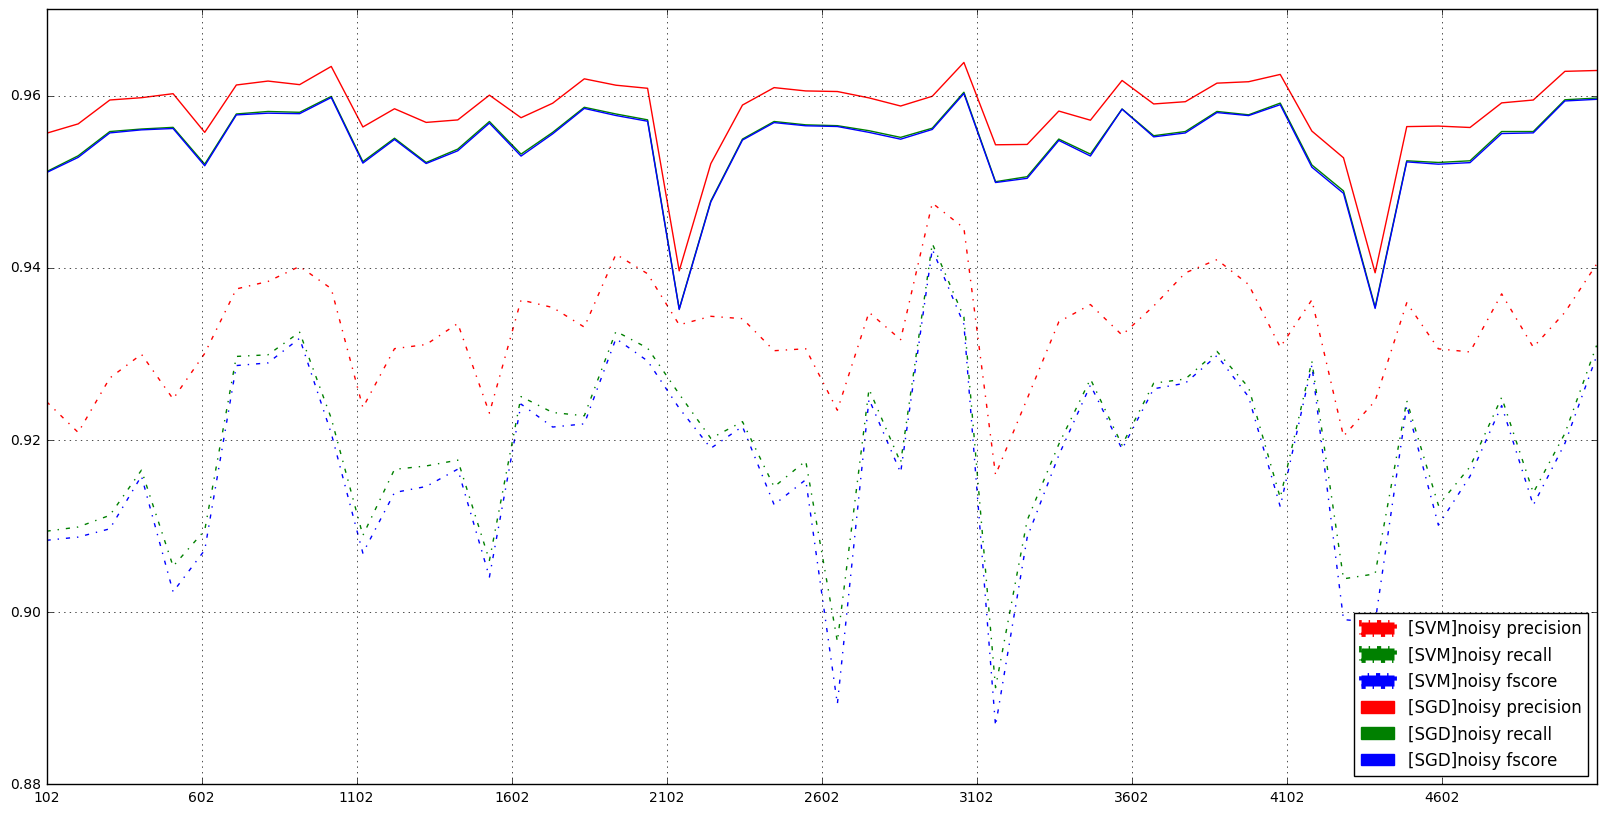

In [242]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.grid(True)

x_axis_vals = range(min_num_indices, max_num_indices, min_num_indices)

major_ticks = np.arange(min_num_indices, max_num_indices, 500) 
minor_ticks = np.arange(min_num_indices, max_num_indices, 100)

plt.xticks(minor_ticks)
plt.xticks(major_ticks)

plt.plot(x_axis_vals, d_nmiss2precision.values(), 'r',
        x_axis_vals, d_nmiss2recall.values(), 'g',
        x_axis_vals, d_nmiss2fscore.values(), 'b')

plt.plot(x_axis_vals, d_nmiss22precision.values(), 'r',
        x_axis_vals, d_nmiss22recall.values(), 'g',
        x_axis_vals, d_nmiss22fscore.values(), 'b', linestyle='-.')

r_patch = mpatches.Patch(color='red', label='[SVM]noisy precision', linestyle='-.', linewidth=3.5)
g_patch = mpatches.Patch(color='green', label='[SVM]noisy recall', linestyle='-.', linewidth=3.5)
b_patch = mpatches.Patch(color='blue', label='[SVM]noisy fscore', linestyle='-.', linewidth=3.5)
r_patch_ = mpatches.Patch(color='red', label='[SGD]noisy precision')
g_patch_ = mpatches.Patch(color='green', label='[SGD]noisy recall')
b_patch_ = mpatches.Patch(color='blue', label='[SGD]noisy fscore')

plt.legend(handles=[r_patch, g_patch, b_patch, r_patch_, g_patch_, b_patch_], loc=4)
# plt.legend(handles=[r_patch, g_patch, b_patch])
plt.show()

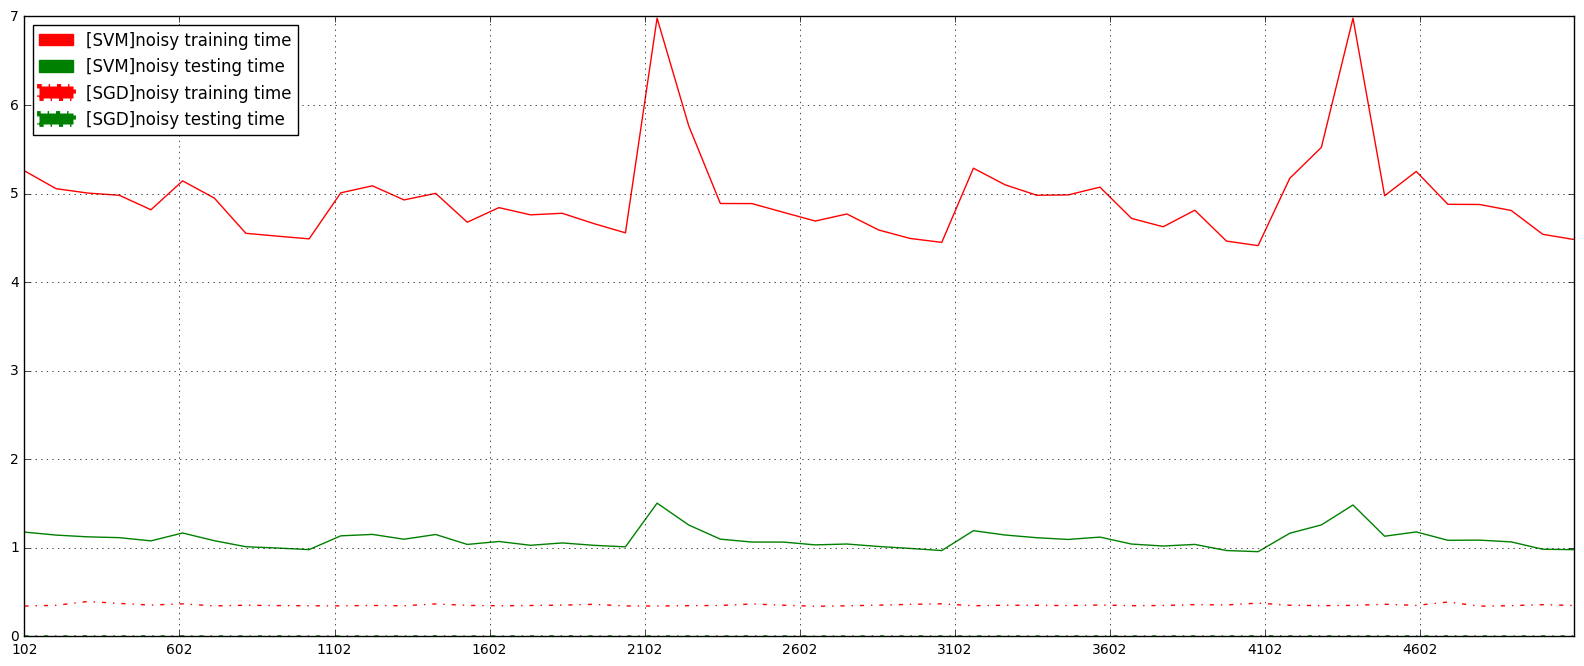

In [247]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.grid(True)

major_ticks = np.arange(min_num_indices, max_num_indices, 500) 
minor_ticks = np.arange(min_num_indices, max_num_indices, 100)

plt.xticks(minor_ticks)
plt.xticks(major_ticks)

plt.plot(x_axis_vals, d_nmiss2ttrain.values(), 'r',
        x_axis_vals, d_nmiss2ttest.values(), 'g')

plt.plot(x_axis_vals, d_nmiss22ttrain.values(), 'r',
        x_axis_vals, d_nmiss22ttest.values(), 'g',linestyle='-.')

r_patch_ = mpatches.Patch(color='red', label='[SVM]noisy training time')
g_patch_ = mpatches.Patch(color='green', label='[SVM]noisy testing time')

r_patch = mpatches.Patch(color='red', label='[SGD]noisy training time', linestyle='-.', linewidth=3.5)
g_patch = mpatches.Patch(color='green', label='[SGD]noisy testing time', linestyle='-.', linewidth=3.5)

plt.legend(handles=[r_patch_, g_patch_, r_patch, g_patch], loc=2)
plt.show()

In [ ]:
precision = {}
recall = {}
fscore = {}
ttrain = {}
ttest = {}
tmp_clf = SVC()

X_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(X)
X_bxcxed = boxCoxData(X_scaled)
X_bxcxed_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(X_bxcxed)

In [215]:
for ndim in range (115, 118):
    tmp_X, times = CreateFeatureSet2(X, X_bxcxed_scaled, ndim, 0)
    print "SVM KBest={:3d}".format(ndim),
    results = GetClassificationPerformance(tmp_clf, tmp_X, y["Activity"].to_frame(), 10, "")
    precision[ndim]=results[0]
    recall[ndim]=results[1]
    fscore[ndim]=results[2]
    ttrain[ndim]=results[3]
    ttest[ndim]=results[4]
    print results

SVM KBest=115  precision:0.79 recall:0.74 fscore:0.73   t_train:7.84 t_test:1.28
[0.78853761991975357, 0.74221215809486074, 0.73176034352591812, 7.8365000724792484, 1.2766999483108521]
SVM KBest=116  precision:0.79 recall:0.74 fscore:0.73   t_train:7.78 t_test:1.28
[0.78786358149954727, 0.74201807768877326, 0.7315511343000537, 7.7777999639511108, 1.2829000234603882]
SVM KBest=117  precision:0.79 recall:0.74 fscore:0.73   t_train:7.91 t_test:1.30
[0.78824919259004966, 0.74221234679724879, 0.73184761345375282, 7.9092000007629393, 1.3031000375747681]


In [ ]:
d_ndim2precision = {}
d_ndim2recall = {}
d_ndim2fscore = {}
d_ndim2ttrain = {}
d_ndim2ttest = {}
d_ndim2tproc = {}

for ndim in range (2, 118):
    X_df, times = CreateFeatureSet(X, ndim, 0)
    print "SVM KBest={:3d}".format(ndim),
    results = GetClassificationPerformance(clf_SVM, X_df, y["Activity"].to_frame(), 10, "")
    d_ndim2precision[ndim]=results[0]
    d_ndim2recall[ndim]=results[1]
    d_ndim2fscore[ndim]=results[2]
    d_ndim2ttrain[ndim]=results[3]
    d_ndim2ttest[ndim]=results[4]
    d_ndim2tproc[ndim]=times[2]

d_ndim22precision = {}
d_ndim22recall = {}
d_ndim22fscore = {}
d_ndim22ttrain = {}
d_ndim22ttest = {}
d_ndim22tproc = {}

for ndim in range (2, 118):
    X_df, times = CreateFeatureSet(X, 0, ndim)
    print "SVM nPCA={:3d}".format(ndim),
    results = GetClassificationPerformance(clf_SVM, X_df, y["Activity"].to_frame(), 10, "")
    d_ndim22precision[ndim]=results[0]
    d_ndim22recall[ndim]=results[1]
    d_ndim22fscore[ndim]=results[2]
    d_ndim22ttrain[ndim]=results[3]
    d_ndim22ttest[ndim]=results[4]
    d_ndim22tproc[ndim]=times[2]

In [205]:
for kbest in range (2, 118):
    printout = "SVM[kbest{:3d}]".format(kbest)
    printout += " precision:{:.2f}".format(d_ndim22precision[kbest])
    printout += " recall:{:.2f}".format(d_ndim22recall[kbest])
    printout += " fscore:{:.2f}  ".format(d_ndim22fscore[kbest])
    printout += " t_train:{:.2f} t_test:{:.2f}".format(d_ndim22ttrain[kbest], d_ndim22ttest[kbest])
    print printout    

SVM[kbest  2] precision:0.64 recall:0.63 fscore:0.61   t_train:1.72 t_test:0.18
SVM[kbest  3] precision:0.80 recall:0.77 fscore:0.76   t_train:0.93 t_test:0.13
SVM[kbest  4] precision:0.80 recall:0.78 fscore:0.77   t_train:0.87 t_test:0.13
SVM[kbest  5] precision:0.82 recall:0.80 fscore:0.80   t_train:0.79 t_test:0.12
SVM[kbest  6] precision:0.84 recall:0.83 fscore:0.82   t_train:0.75 t_test:0.11
SVM[kbest  7] precision:0.86 recall:0.84 fscore:0.84   t_train:0.67 t_test:0.11
SVM[kbest  8] precision:0.86 recall:0.85 fscore:0.85   t_train:0.65 t_test:0.11
SVM[kbest  9] precision:0.87 recall:0.86 fscore:0.86   t_train:0.65 t_test:0.11
SVM[kbest 10] precision:0.88 recall:0.88 fscore:0.88   t_train:0.63 t_test:0.10
SVM[kbest 11] precision:0.89 recall:0.88 fscore:0.88   t_train:0.63 t_test:0.10
SVM[kbest 12] precision:0.89 recall:0.88 fscore:0.88   t_train:0.63 t_test:0.11
SVM[kbest 13] precision:0.90 recall:0.89 fscore:0.89   t_train:0.63 t_test:0.11
SVM[kbest 14] precision:0.90 recall:0.89

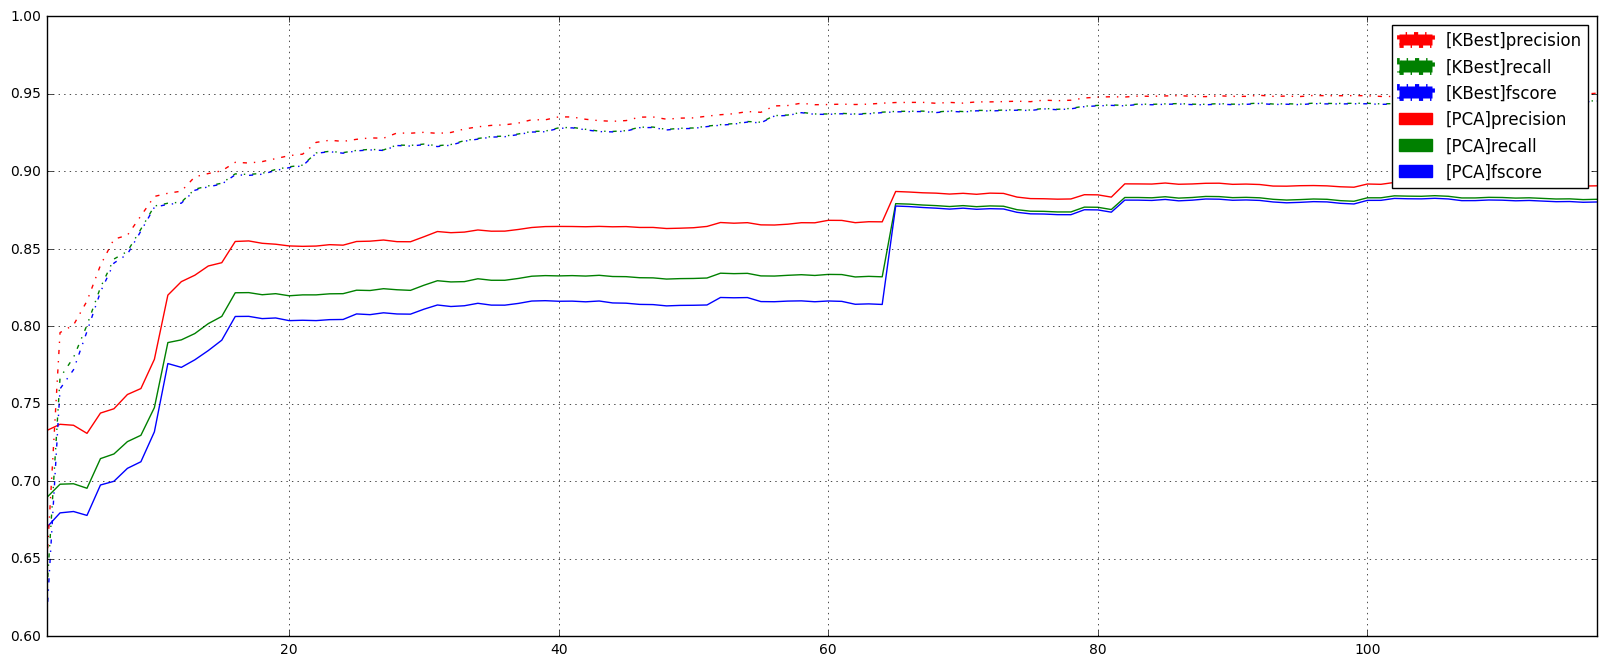

In [165]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.grid(True)

major_ticks = np.arange(0, 120, 20) 
minor_ticks = np.arange(0, 120, 5)

plt.xticks(minor_ticks)
plt.xticks(major_ticks)

plt.plot(d_ndim2precision.keys(), d_ndim2precision.values(), 'r',
        d_ndim2recall.keys(), d_ndim2recall.values(), 'g',
        d_ndim2fscore.keys(), d_ndim2fscore.values(), 'b')

plt.plot(d_ndim22precision.keys(), d_ndim22precision.values(), 'r',
        d_ndim22recall.keys(), d_ndim22recall.values(), 'g',
        d_ndim22fscore.keys(), d_ndim22fscore.values(), 'b', linestyle='-.')

r_patch = mpatches.Patch(color='red', label='[KBest]precision', linestyle='-.', linewidth=3.5)
g_patch = mpatches.Patch(color='green', label='[KBest]recall', linestyle='-.', linewidth=3.5)
b_patch = mpatches.Patch(color='blue', label='[KBest]fscore', linestyle='-.', linewidth=3.5)
r_patch_ = mpatches.Patch(color='red', label='[PCA]precision')
g_patch_ = mpatches.Patch(color='green', label='[PCA]recall')
b_patch_ = mpatches.Patch(color='blue', label='[PCA]fscore')

plt.legend(handles=[r_patch, g_patch, b_patch, r_patch_, g_patch_, b_patch_])
plt.show()
    

In [104]:
for kbest in range (2, 4):
    for n_components in range (112, 140):
        X_combined_df, times = CreateFeatureSet(X, kbest, n_components)
        print "SVM[kbest{:3d} npca{:3d}]".format(kbest, n_components),
        results = GetClassificationPerformance(clf_SVM, X_combined_df, y["Activity"].to_frame(), 10, "")
        print times

SVM[kbest  2 npca112]  precision:0.95 recall:0.94 fscore:0.94   t_train:1.49 t_test:0.35
[13.780999898910522, 0.818000078201294, 14.611999988555908]
SVM[kbest  2 npca113]  precision:0.95 recall:0.94 fscore:0.94   t_train:1.50 t_test:0.35
[13.263000011444092, 0.8090000152587891, 14.080999851226807]
SVM[kbest  2 npca114]  precision:0.95 recall:0.94 fscore:0.94   t_train:1.51 t_test:0.36
[13.358000040054321, 0.8309998512268066, 14.197999954223633]
SVM[kbest  2 npca115]  precision:0.95 recall:0.94 fscore:0.94   t_train:1.52 t_test:0.36
[13.26200008392334, 0.8510000705718994, 14.121999979019165]
SVM[kbest  2 npca116]  precision:0.95 recall:0.94 fscore:0.94   t_train:1.53 t_test:0.36
[13.210000038146973, 0.8359999656677246, 14.055999994277954]
SVM[kbest  2 npca117]  precision:0.95 recall:0.95 fscore:0.95   t_train:1.54 t_test:0.36
[13.26200008392334, 0.8700001239776611, 14.14300012588501]
SVM[kbest  2 npca118]  precision:0.95 recall:0.95 fscore:0.95   t_train:1.56 t_test:0.37
[13.28199982643

In [116]:
X_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(X)
X_bxcxed = boxCoxData(X_scaled)
X_bxcxed_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(X_bxcxed)

d_kbest_npca_to_precision = {}
d_kbest_npca_recall = {}
d_kbest_npca_f1score = {}

kbest_max = X.shape[1]/5

kbest_npca = []
for kbest in range (2, kbest_max):
    f_selector = SelectKBest(k=kbest)
    Xs = f_selector.fit(X, y['Activity'].to_frame()).transform(X)
    f_selected_indices = f_selector.get_support(indices=False)
    Xs_cols = X.columns[f_selected_indices]
    Xs_df = pd.DataFrame(Xs, columns = Xs_cols)
    
    num_components = range(2, X.shape[1]/10, 2) + range(X.shape[1]/10, X.shape[1]/3, X.shape[1]/40)

    for n_components in num_components:
        pca = PCA(n_components=n_components).fit(X)
    #     print pca.explained_variance_ratio_
        printout = "n_components: {:d}".format(n_components)
        X_pcaed = pca.transform(X)

        dimensions = []
        for i in range(0, n_components):
            dimensions.append("comp_{:3d}".format(i))

        X_pcaed_df = pd.DataFrame(X_pcaed, columns = dimensions)
        X_combined = pd.concat([Xs_df, X_pcaed_df], axis=1)

        # NOTE: Uncomment for the results
#         print "SVM[kbest{:3d} npca{:3d}]".format(kbest, n_components),
#         results = GetClassificationPerformance(clf_SVM, X_combined, y["Activity"].to_frame(), 10, "")
#         kbest_npca.append(results)

In [92]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

def ScaleData(data):
    data_scaled = []
    for feature in range(data.shape[1]):
        data_scaled_feature = preprocessing.scale(data[:,feature])
        if feature == 0:
            data_scaled = data_scaled_feature
        else:
            data_scaled = np.column_stack([data_scaled, data_scaled_feature])
    return data_scaled

def predict(clf, features):
    start = time()
    pred = clf.predict(features)
    end = time()
    return end - start, pred

# kbest_param_vals = [5, 10, 15, 20, 30, 50, 100, 200, X.shape[1]]
# pca_n_components = [2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

# kbest_param_vals = [16]
# pca_n_components = [2]

kbest_param_vals = [5]
pca_n_components = [50]

for kbest in kbest_param_vals:
    start = time()
    #choose kbest feature dimensions
    f_selector = SelectKBest(k=kbest)
    X_slctd = f_selector.fit(X, y['Activity']).transform(X)
    f_selected_indices = f_selector.get_support(indices=False)
    X_slctd_cols = X.columns[f_selected_indices]
    
    #transform these features to another space where they are less skewed
    X_slctd_tformed = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(X_slctd)
    X_slctd_tformed = boxCoxData(X_slctd_tformed)
    X_slctd_tformed = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(X_slctd_tformed)
    X_slctd_tformed = pd.DataFrame(data=X_slctd_tformed, index=range(X_slctd_tformed.shape[0]), columns=X_slctd_cols)
    end = time()
    
    for pca_n in pca_n_components:
        column_names = []
        for i in range(pca_n):
            column_names.append("component{:2d}".format(i))
            
        start_pca = time()
        pca = PCA(n_components=pca_n).fit(X)
        X_pcaed = pca.transform(X)
        X_pcaed = pd.DataFrame(data=X_pcaed, index=range(X_pcaed.shape[0]), columns=column_names)
        
        X_combined = pd.concat([X_slctd_tformed, X_pcaed], axis=1)
        end_pca = time()
        t_proc = (end - start) + (end_pca - start_pca)
        results_precision = []
        results_recall = []
        results_fscore = []
        kfold = cross_validation.KFold(X_combined.shape[0], n_folds=10, shuffle=False, random_state=42)
        t_trains = []
        t_tests = []
        for train, test in kfold:
            t_train_s = time()
            clf_SVM.fit(X_combined.iloc[train], y_[train])
            t_trains.append( time() - t_train_s )
            t_test, y_pred = predict(clf_SVM, X_combined.iloc[test])
            t_tests.append(t_test)
            precision, recall, fscore, support = precision_recall_fscore_support(y_[test], y_pred, 
                                                                                 average='weighted')
            results_precision.append(precision)
            results_recall.append(recall)
            results_fscore.append(fscore)

        printout = "(kbest{:3d})(pca_n{:3d})".format(kbest, pca_n)
        printout += "  precision: {:.2f}".format(np.mean(results_precision))
        printout += "  recall: {:.2f}".format(np.mean(results_recall))
        printout += "  fscore: {:.2f}  ".format(np.mean(results_fscore))
        printout += "  t_proc: {:.2f} t_train: {:.2f} t_test: {:.2f}".format(t_proc, np.mean(t_trains), np.mean(t_tests))
        print printout

(kbest  5)(pca_n 50)  precision: 0.94  recall: 0.93  fscore: 0.93    t_proc: 1.13 t_train: 0.86 t_test: 0.19


In [144]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit

X_pcaed_df, times = CreateFeatureSet(X, 0, 117)

param_grid = [
  {'C': [1, 10, 100, 1000], 'gamma': ['auto'], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
d_params2results = {}
d_cnt2params = {}
cnt = 0
for params in param_grid:
    for c_val in params['C']:
        for kernel_val in params['kernel']:
            for gamma_val in params['gamma']:
                clf_SVM_ = SVC(C=c_val, kernel=kernel_val, gamma=gamma_val)
                d_cnt2params[cnt] = {'C': c_val, 'gamma': gamma_val, 'kernel': kernel_val}
                d_params2results[cnt] = GetClassificationPerformance(clf_SVM_, X_pcaed_df, y["Activity"].to_frame(), 10, "")
                cnt += 1

 precision:0.95 recall:0.95 fscore:0.95   t_train:0.75 t_test:0.10
 precision:0.95 recall:0.95 fscore:0.95   t_train:1.63 t_test:0.09
 precision:0.95 recall:0.95 fscore:0.95   t_train:9.00 t_test:0.09
 precision:0.95 recall:0.95 fscore:0.95   t_train:83.33 t_test:0.09
 precision:0.93 recall:0.92 fscore:0.92   t_train:2.98 t_test:0.67
 precision:0.88 recall:0.86 fscore:0.86   t_train:7.53 t_test:1.23
 precision:0.95 recall:0.95 fscore:0.95   t_train:1.31 t_test:0.31
 precision:0.93 recall:0.92 fscore:0.92   t_train:2.94 t_test:0.67
 precision:0.96 recall:0.95 fscore:0.95   t_train:0.87 t_test:0.17
 precision:0.95 recall:0.95 fscore:0.95   t_train:1.31 t_test:0.31
 precision:0.96 recall:0.95 fscore:0.95   t_train:0.96 t_test:0.14
 precision:0.96 recall:0.95 fscore:0.95   t_train:0.87 t_test:0.17


In [145]:
for i in range(cnt):
    print str(d_cnt2params[i]) + " ",
    print d_params2results[i]

# kfold = cross_validation.KFold(X_combined.shape[0], n_folds=10, shuffle=False, random_state=42)
# grid = GridSearchCV(SVC(), param_grid=param_grid, cv=kfold)
# grid.fit(X_combined, y_)

# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))
# print grid.grid_scores_

{'kernel': 'linear', 'C': 1, 'gamma': 'auto'}  [0.95435768550751443, 0.95067696981705296, 0.95042704072511253, 0.75270001888275151, 0.10220000743865967]
{'kernel': 'linear', 'C': 10, 'gamma': 'auto'}  [0.95491814980576062, 0.95116240671025698, 0.95091244219119697, 1.6251999616622925, 0.091400051116943354]
{'kernel': 'linear', 'C': 100, 'gamma': 'auto'}  [0.9529746852620733, 0.94931774651608225, 0.94906801540404362, 9.0042000055313114, 0.08670001029968262]
{'kernel': 'linear', 'C': 1000, 'gamma': 'auto'}  [0.95285760624428162, 0.94931774651608225, 0.94906792324642075, 83.325100016593936, 0.087100005149841314]
{'kernel': 'rbf', 'C': 1, 'gamma': 0.001}  [0.92837257115584071, 0.92213092171681443, 0.92135103886798575, 2.9771999597549437, 0.67490007877349856]
{'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}  [0.88129747661684699, 0.86270278430373537, 0.85761911805524316, 7.530699992179871, 1.227299976348877]
{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}  [0.95242952488143939, 0.9482493135950637, 0.94

In [219]:
n_pca = 118

d_npca2precision = {}
d_npca2recall = {}
d_npca2fscore = {}
d_npca2ttrain = {}
d_npca2ttest = {}

tmp_clf_tuned = SVC(C=100, kernel='rbf', gamma=0.001, class_weight='balanced')

for n_components in range (2, n_pca):
    Xs_df, times = CreateFeatureSet(X, 0, n_components)
    print "SVM nPCA={:3d}".format(n_components),
    result = GetClassificationPerformance(tmp_clf_tuned, Xs_df, y["Activity"].to_frame(), 10, "")
    d_npca2precision = result[0]
    d_npca2recall = result[1]
    d_npca2fscore = result[2]
    d_npca2ttrain = result[3]
    d_npca2ttest = result[4]

 SVM nPCA=  2  precision:0.64 recall:0.63 fscore:0.61   t_train:2.26 t_test:0.26
SVM nPCA=  3  precision:0.79 recall:0.77 fscore:0.77   t_train:1.17 t_test:0.19
SVM nPCA=  4  precision:0.80 recall:0.78 fscore:0.78   t_train:1.14 t_test:0.18
SVM nPCA=  5  precision:0.82 recall:0.81 fscore:0.80   t_train:1.01 t_test:0.17
SVM nPCA=  6  precision:0.84 recall:0.83 fscore:0.83   t_train:0.91 t_test:0.15
SVM nPCA=  7  precision:0.86 recall:0.85 fscore:0.85   t_train:0.81 t_test:0.14
SVM nPCA=  8  precision:0.87 recall:0.86 fscore:0.86   t_train:0.75 t_test:0.13
SVM nPCA=  9  precision:0.88 recall:0.87 fscore:0.87   t_train:0.74 t_test:0.13
SVM nPCA= 10  precision:0.89 recall:0.89 fscore:0.89   t_train:0.70 t_test:0.12
SVM nPCA= 11  precision:0.89 recall:0.88 fscore:0.88   t_train:0.71 t_test:0.13
SVM nPCA= 12  precision:0.89 recall:0.88 fscore:0.88   t_train:0.71 t_test:0.13
SVM nPCA= 13  precision:0.89 recall:0.89 fscore:0.89   t_train:0.71 t_test:0.13
SVM nPCA= 14  precision:0.90 recall:0.8

In [220]:
n_pca = 118

d_npca22precision = {}
d_npca22recall = {}
d_npca22fscore = {}
d_npca22ttrain = {}
d_npca22ttest = {}

tmp_clf_tuned_nobalance = SVC(C=100, kernel='rbf', gamma=0.001)

for n_components in range (2, n_pca):
    Xs_df, times = CreateFeatureSet(X, 0, n_components)
    print "SVM nPCA={:3d}".format(n_components),
    result = GetClassificationPerformance(tmp_clf_tuned_nobalance, Xs_df, y["Activity"].to_frame(), 10, "")
    d_npca22precision = result[0]
    d_npca22recall = result[1]
    d_npca22fscore = result[2]
    d_npca22ttrain = result[3]
    d_npca22ttest = result[4]

SVM nPCA=  2  precision:0.64 recall:0.63 fscore:0.61   t_train:1.97 t_test:0.26
SVM nPCA=  3  precision:0.79 recall:0.77 fscore:0.76   t_train:1.09 t_test:0.19
SVM nPCA=  4  precision:0.80 recall:0.78 fscore:0.77   t_train:1.06 t_test:0.18
SVM nPCA=  5  precision:0.82 recall:0.81 fscore:0.80   t_train:0.88 t_test:0.17
SVM nPCA=  6  precision:0.84 recall:0.83 fscore:0.83   t_train:0.83 t_test:0.16
SVM nPCA=  7  precision:0.86 recall:0.85 fscore:0.85   t_train:0.74 t_test:0.14
SVM nPCA=  8  precision:0.87 recall:0.86 fscore:0.86   t_train:0.70 t_test:0.13
SVM nPCA=  9  precision:0.88 recall:0.87 fscore:0.87   t_train:0.70 t_test:0.13
SVM nPCA= 10  precision:0.89 recall:0.88 fscore:0.88   t_train:0.65 t_test:0.12
SVM nPCA= 11  precision:0.89 recall:0.88 fscore:0.88   t_train:0.67 t_test:0.12
SVM nPCA= 12  precision:0.89 recall:0.88 fscore:0.88   t_train:0.68 t_test:0.13
SVM nPCA= 13  precision:0.89 recall:0.89 fscore:0.89   t_train:0.67 t_test:0.13
SVM nPCA= 14  precision:0.90 recall:0.89

In [204]:
from random import sample
step = 100
clf = SVC(C=100, kernel='rbf', gamma=0.001)

subsetsizes = range(step, X_pcaed_df.shape[0], step)

d_ds2precision = {}
d_ds2recall = {}
d_ds2fscore = {}
d_ds2ttrain = {}
d_ds2ttest = {}

for subsetsize in subsetsizes:
    random_index = sample(range(0, X_pcaed_df.shape[0]), subsetsize)
    
    X_pcaed_df_subset = X_pcaed_df.iloc[random_index]
    y_subset = y["Activity"].iloc[random_index]

    print "SVM d:{:5d}".format(subsetsize),
    results = GetClassificationPerformance(clf, X_pcaed_df_subset, y_subset, 10, "")
    d_ds2precision[subsetsize]= results[0]
    d_ds2recall[subsetsize]= results[1]
    d_ds2fscore[subsetsize]= results[2]
    d_ds2ttrain[subsetsize]= results[3]
    d_ds2ttest[subsetsize]= results[4]

d_ds22precision = {}
d_ds22recall = {}
d_ds22fscore = {}
d_ds22ttrain = {}
d_ds22ttest = {}

for subsetsize in subsetsizes:
    random_index = sample(range(0, X_pcaed_df.shape[0]), subsetsize)
    
    X_pcaed_df_subset = X_pcaed_df.iloc[random_index]
    y_subset = y["Activity"].iloc[random_index]

    print "SVM d:{:5d}".format(subsetsize),
    results = GetClassificationPerformance(clf_SGD, X_pcaed_df_subset, y_subset, 10, "")
    d_ds22precision[subsetsize]= results[0]
    d_ds22recall[subsetsize]= results[1]
    d_ds22fscore[subsetsize]= results[2]
    d_ds22ttrain[subsetsize]= results[3]
    d_ds22ttest[subsetsize]= results[4]

SVM d:  100  precision:0.88 recall:0.86 fscore:0.85   t_train:0.00 t_test:0.00
SVM d:  200  precision:0.94 recall:0.92 fscore:0.92   t_train:0.00 t_test:0.00
SVM d:  300  precision:0.92 recall:0.91 fscore:0.91   t_train:0.01 t_test:0.00
SVM d:  400  precision:0.97 recall:0.96 fscore:0.96   t_train:0.01 t_test:0.00
SVM d:  500  precision:0.94 recall:0.93 fscore:0.93   t_train:0.01 t_test:0.00
SVM d:  600  precision:0.94 recall:0.94 fscore:0.94   t_train:0.02 t_test:0.00
SVM d:  700  precision:0.96 recall:0.96 fscore:0.96   t_train:0.02 t_test:0.00
SVM d:  800  precision:0.96 recall:0.96 fscore:0.96   t_train:0.02 t_test:0.00
SVM d:  900  precision:0.97 recall:0.96 fscore:0.96   t_train:0.03 t_test:0.00
SVM d: 1000  precision:0.96 recall:0.95 fscore:0.95   t_train:0.03 t_test:0.01
SVM d: 1100  precision:0.97 recall:0.97 fscore:0.97   t_train:0.04 t_test:0.01
SVM d: 1200  precision:0.95 recall:0.95 fscore:0.95   t_train:0.04 t_test:0.01
SVM d: 1300  precision:0.97 recall:0.96 fscore:0.96 

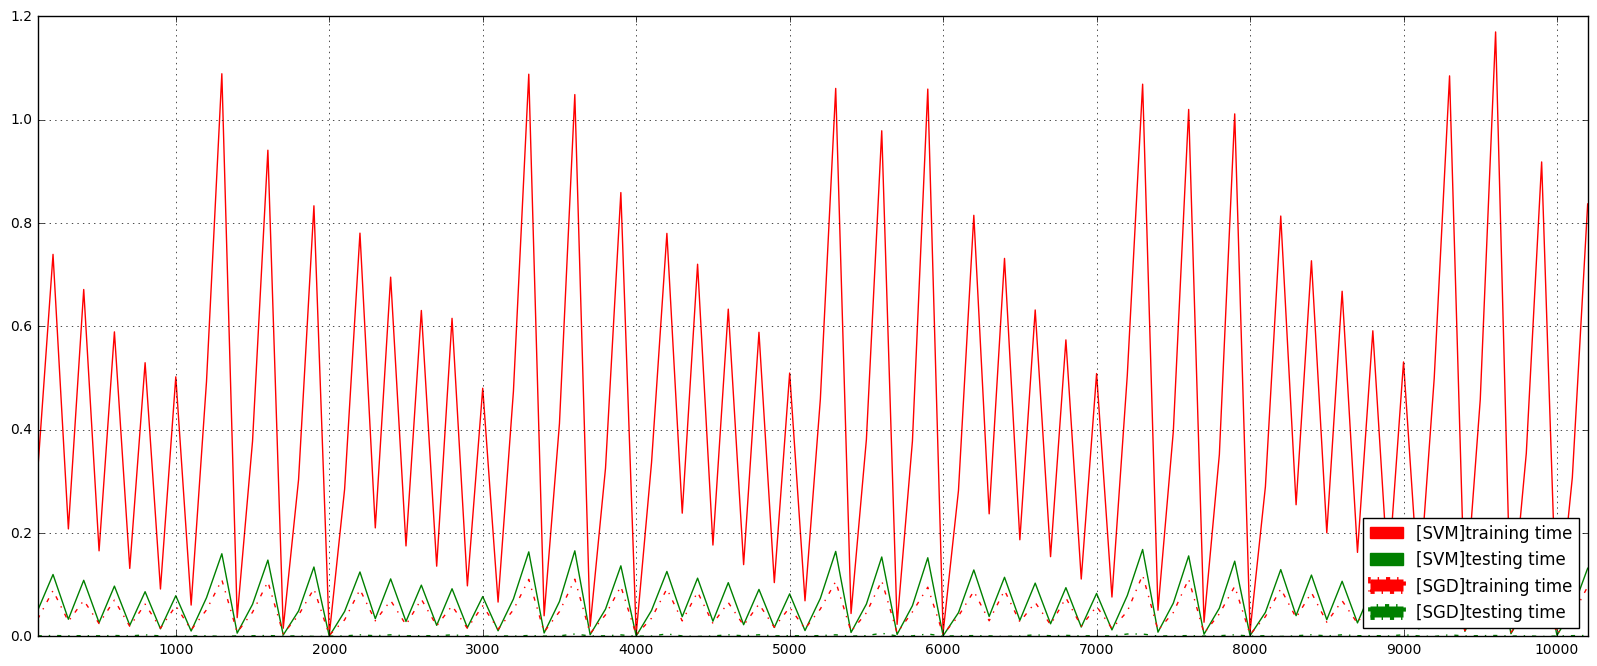

In [221]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.grid(True)

major_ticks = np.arange(0, X_pcaed_df.shape[0], 1000) 
minor_ticks = np.arange(0, X_pcaed_df.shape[0], 100)

plt.xticks(minor_ticks)
plt.xticks(major_ticks)

plt.plot(subsetsizes, d_ds2ttrain.values(), 'r',
        subsetsizes, d_ds2ttest.values(), 'g')

plt.plot(subsetsizes, d_ds22ttrain.values(), 'r',
        subsetsizes, d_ds22ttest.values(), 'g',linestyle='-.')

r_patch_ = mpatches.Patch(color='red', label='[SVM]training time')
g_patch_ = mpatches.Patch(color='green', label='[SVM]testing time')

r_patch = mpatches.Patch(color='red', label='[SGD]training time', linestyle='-.', linewidth=3.5)
g_patch = mpatches.Patch(color='green', label='[SGD]testing time', linestyle='-.', linewidth=3.5)

plt.legend(handles=[r_patch_, g_patch_, r_patch, g_patch], loc=4)
plt.show()

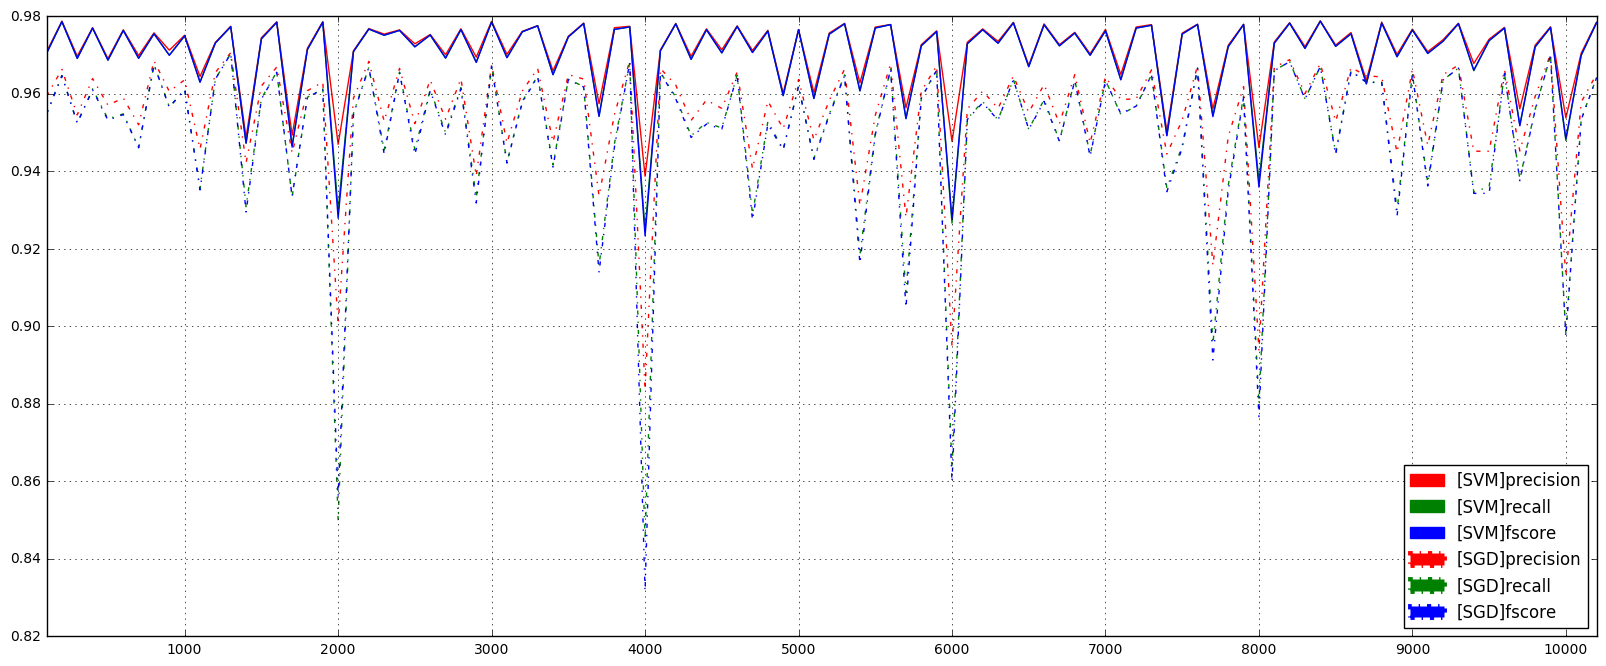

In [191]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.grid(True)

major_ticks = np.arange(0, X_pcaed_df.shape[0], 1000) 
minor_ticks = np.arange(0, X_pcaed_df.shape[0], 100)

plt.xticks(minor_ticks)
plt.xticks(major_ticks)

plt.plot(subsetsizes, d_ds2precision.values(), 'r',
        subsetsizes, d_ds2recall.values(), 'g',
        subsetsizes, d_ds2fscore.values(), 'b')

plt.plot(subsetsizes, d_ds22precision.values(), 'r',
        subsetsizes, d_ds22recall.values(), 'g',
        subsetsizes, d_ds22fscore.values(), 'b', linestyle='-.')

r_patch_ = mpatches.Patch(color='red', label='[SVM]precision')
g_patch_ = mpatches.Patch(color='green', label='[SVM]recall')
b_patch_ = mpatches.Patch(color='blue', label='[SVM]fscore')
r_patch = mpatches.Patch(color='red', label='[SGD]precision', linestyle='-.', linewidth=3.5)
g_patch = mpatches.Patch(color='green', label='[SGD]recall', linestyle='-.', linewidth=3.5)
b_patch = mpatches.Patch(color='blue', label='[SGD]fscore', linestyle='-.', linewidth=3.5)

plt.legend(handles=[r_patch_, g_patch_, b_patch_, r_patch, g_patch, b_patch], loc=4)
plt.show()

It is now time to optimize training parameters of the models while incorporating best set of features. My hypothesis is that this will yield in the best classification performance.

In [128]:
clf_SVM = SVC(C=100, kernel='rbf', gamma=0.001)
clfs = {clf_SGD, clf_Ada, clf_DTR, clf_KNC, clf_GNB, clf_SVM}

for clf in clfs:
    printout = ""
    if clf == clf_SGD: printout = "SGD"
    elif clf == clf_Ada: printout = "Ada"
    elif clf == clf_DTR: printout = "DTR"
    elif clf == clf_KNC: printout = "KNC"
    elif clf == clf_GNB: printout = "GNB"
    elif clf == clf_SVM: printout = "SVM"

    GetClassificationPerformance(clf, X_pcaed_df, y["Activity"].to_frame(), 10, printout)

DTR precision:0.79 recall:0.79 fscore:0.79   t_train:2.09 t_test:0.00
SGD precision:0.95 recall:0.95 fscore:0.95   t_train:0.14 t_test:0.00
GNB precision:0.81 recall:0.79 fscore:0.79   t_train:0.05 t_test:0.02
Ada precision:0.33 recall:0.42 fscore:0.30   t_train:11.87 t_test:0.02
SVM precision:0.95 recall:0.95 fscore:0.95   t_train:2.43 t_test:0.58
KNC precision:0.91 recall:0.91 fscore:0.91   t_train:0.13 t_test:1.66


In [ ]:
GetClassificationPerformance(clf_SVM, X_pcaed_df, y["Activity"].to_frame(), 10, printout)

In [22]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    return r2_score(y_true, y_predict)

from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):

    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    params = {'max_depth': range(1,20)}
    
    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    regressor = DecisionTreeRegressor(max_depth = params['max_depth'], random_state=42)
    grid = GridSearchCV(regressor, param_grid=params, scoring=scoring_fnc)
    grid = grid.fit(X, y)
    return grid.best_estimator_

# clf = fit_model(X,y)
clf = fit_model(X_train,y_train)

print clf.score(X_train, y_train)
print clf.score(X_test, y_test)

0.190959174602
-7.59452573956
